
Querying HV network around Kiluea (within 1.0°)...
  HV.AHUD.EHZ | 6.0 km | Start:2011-04-06T00:00:00.000000Z End:None | Access:Yes
  HV.AHUD.HHZ | 6.0 km | Start:2023-05-04T00:00:00.000000Z End:None | Access:Yes
  HV.AHUD.HHZ | 6.0 km | Start:2023-05-04T00:00:00.000000Z End:2023-05-04T00:00:01.000000Z | Access:Yes
  HV.AHUD.HHZ | 6.0 km | Start:2023-05-04T00:00:01.000000Z End:2023-05-04T01:00:00.000000Z | Access:Yes
  HV.AIN.EHZ | 18.7 km | Start:2007-04-01T12:00:00.000000Z End:2011-08-12T00:00:00.000000Z | Access:Yes
  HV.AIND.HHZ | 18.7 km | Start:2011-08-09T00:00:00.000000Z End:2012-01-04T00:00:00.000000Z | Access:Yes
  HV.AIND.HHZ | 18.7 km | Start:2012-01-04T00:00:00.000000Z End:2014-09-23T00:00:00.000000Z | Access:Yes
  HV.AIND.HHZ | 18.7 km | Start:2014-09-23T00:00:00.000000Z End:2016-05-10T00:00:00.000000Z | Access:Yes
  HV.AIND.HHZ | 18.7 km | Start:2016-05-10T00:00:00.000000Z End:2021-04-30T00:00:00.000000Z | Access:Yes
  HV.AIND.HHZ | 18.7 km | Start:2021-04-30T00:00:00.00

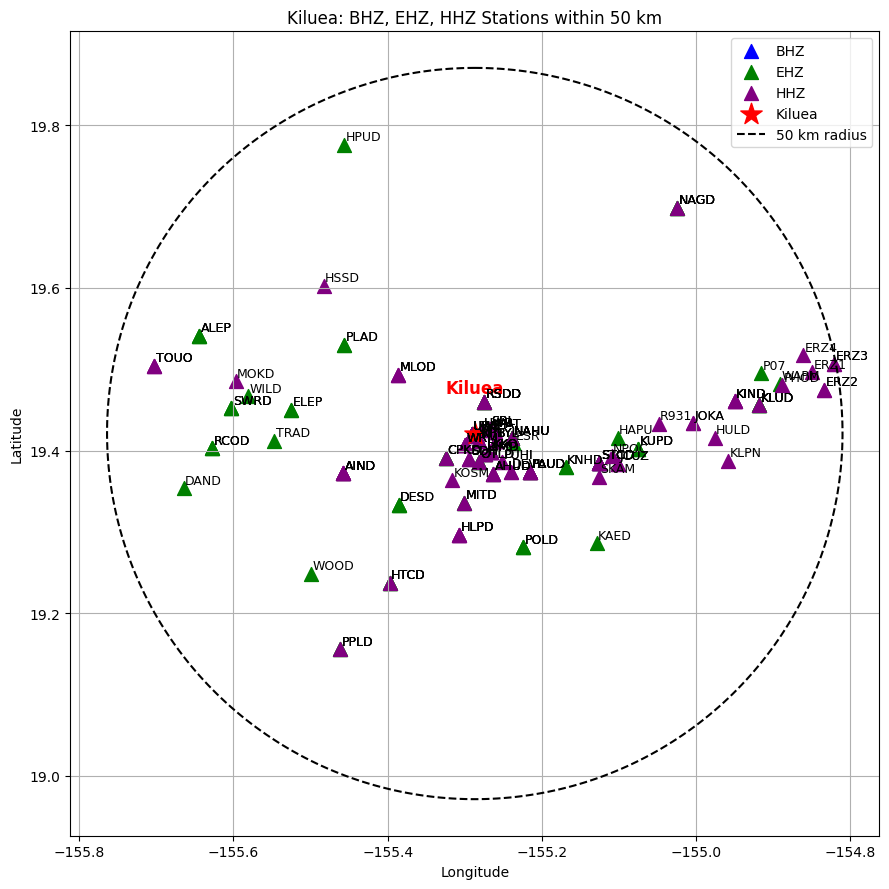

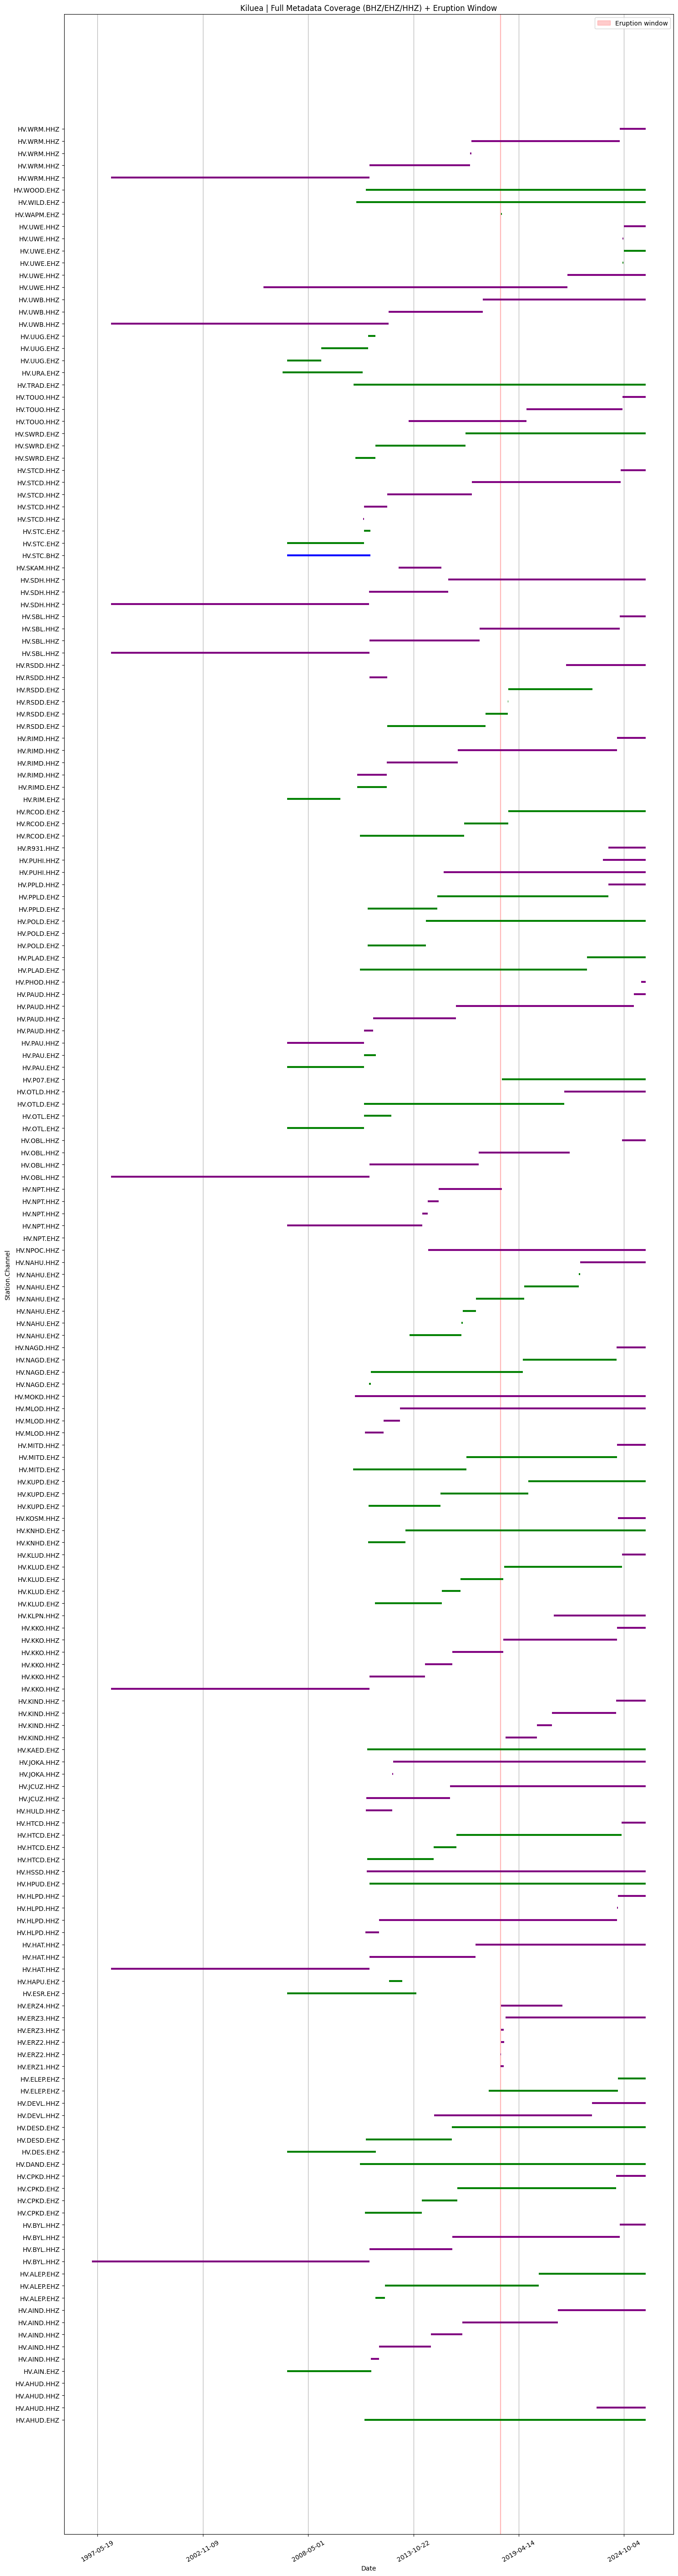

In [2]:
"""
Kilauea Multi-Network Station Coverage Report
Filtered to vertical components: BHZ, EHZ, HHZ
- Full metadata coverage shown
- Eruption window overlay
- Station names on map
- Circle computed using true haversine great-circle geometry
- Timeline 
"""

from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings

# -------------------------------
# User Parameters
# -------------------------------
client = Client("IRIS")

volcano_name = "Kiluea"
target_lat = 19.421
target_lon = -155.287
radius_km = 50
max_search_deg = 1.0
network_list = ["HV"]
channel_filter = ["BHZ", "EHZ", "HHZ"]

eruption_start = UTCDateTime("2018-04-23T00:00:00")
eruption_end   = UTCDateTime("2018-05-05T23:59:00")

warnings.filterwarnings("ignore", category=RuntimeWarning)

# -------------------------------
# Helper functions
# -------------------------------
def haversine(lat1, lon1, lat2, lon2):
    """Compute great-circle distance in km between two lat/lon points."""
    R = 6371.0
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

def destination_point(lat1, lon1, bearing_deg, distance_km):
    """Compute destination point given start lat/lon, bearing (deg), and distance (km)."""
    R = 6371.0
    bearing = math.radians(bearing_deg)
    phi1 = math.radians(lat1)
    lambda1 = math.radians(lon1)
    delta = distance_km / R
    phi2 = math.asin(math.sin(phi1)*math.cos(delta) + math.cos(phi1)*math.sin(delta)*math.cos(bearing))
    lambda2 = lambda1 + math.atan2(math.sin(bearing)*math.sin(delta)*math.cos(phi1),
                                   math.cos(delta) - math.sin(phi1)*math.sin(phi2))
    return math.degrees(phi2), (math.degrees(lambda2) + 540) % 360 - 180  # normalize lon

# -------------------------------
# Collect metadata
# -------------------------------
all_records = []

for network_code in network_list:
    print(f"\nQuerying {network_code} network around {volcano_name} (within {max_search_deg}°)...")
    try:
        inventory = client.get_stations(
            network=network_code,
            level="channel",
            latitude=target_lat,
            longitude=target_lon,
            maxradius=max_search_deg
        )
    except Exception as e:
        print(f" Could not fetch metadata for {network_code}: {e}")
        continue

    for net in inventory:
        for sta in net:
            dist_km = haversine(target_lat, target_lon, sta.latitude, sta.longitude)
            if dist_km > radius_km:
                continue

            for cha in sta:
                if cha.code not in channel_filter:
                    continue

                start_md = getattr(cha, "start_date", None)
                end_md = getattr(cha, "end_date", None)
                restricted_status = getattr(cha, "restricted_status", None)
                open_access = "No" if (restricted_status == "closed") else "Yes"

                all_records.append({
                    "Volcano": volcano_name,
                    "Network": net.code,
                    "Station": sta.code,
                    "Channel": cha.code,
                    "Latitude": sta.latitude,
                    "Longitude": sta.longitude,
                    "Elevation_m": sta.elevation,
                    "Distance_km": round(dist_km, 2),
                    "Start_Metadata": start_md,
                    "End_Metadata": end_md,
                    "OpenAccess": open_access
                })

                print(f"  {net.code}.{sta.code}.{cha.code} | {dist_km:.1f} km | Start:{start_md} End:{end_md} | Access:{open_access}")

# -------------------------------
# Build DataFrame
# -------------------------------
df_cov = pd.DataFrame(all_records)
if df_cov.empty:
    raise ValueError("No BHZ/EHZ/HHZ channels found within the specified range.")

df_cov["Start_dt"] = pd.to_datetime(df_cov["Start_Metadata"].apply(lambda x: x.datetime if x else None))
df_cov["End_dt"]   = pd.to_datetime(df_cov["End_Metadata"].apply(lambda x: x.datetime if x else None))

csv_filename = f"{volcano_name.replace(' ','_')}_BHZ_EHZ_HHZ_fullcoverage.csv"
df_cov.to_csv(csv_filename, index=False)
print(f"\n Saved full coverage CSV: {csv_filename}")

# -------------------------------
# Map Plot with Haversine Circle
# -------------------------------
plt.figure(figsize=(9, 9))
channel_colors = {"BHZ": "blue", "EHZ": "green", "HHZ": "purple"}

# Plot stations by channel type
for ch, color in channel_colors.items():
    subset = df_cov[df_cov["Channel"] == ch]
    plt.scatter(subset["Longitude"], subset["Latitude"], c=color, s=100, marker="^", label=ch)

# Volcano marker
plt.scatter(target_lon, target_lat, c="red", s=260, marker="*", label=volcano_name)
plt.text(target_lon, target_lat + 0.05, volcano_name, color="red", fontsize=12, weight="bold", ha="center")

# Add station labels
for _, row in df_cov.iterrows():
    plt.text(row["Longitude"] + 0.002, row["Latitude"] + 0.002, f"{row['Station']}", fontsize=9, ha="left", va="bottom")

# Compute and plot the true haversine circle
circle_lats, circle_lons = [], []
for bearing in np.linspace(0, 360, 360):
    lat2, lon2 = destination_point(target_lat, target_lon, bearing, radius_km)
    circle_lats.append(lat2)
    circle_lons.append(lon2)

plt.plot(circle_lons, circle_lats, 'k--', linewidth=1.5, label=f"{radius_km} km radius")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"{volcano_name}: BHZ, EHZ, HHZ Stations within {radius_km} km")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# Timeline Plot
# -------------------------------
plt.figure(figsize=(15, max(8, len(df_cov) * 0.3)))
y_labels, y_pos = [], []

for i, row in enumerate(df_cov.itertuples()):
    y_labels.append(f"{row.Network}.{row.Station}.{row.Channel}")
    y_pos.append(i)
    color = channel_colors.get(row.Channel, "gray")
    plt.hlines(i, mdates.date2num(row.Start_dt),
               mdates.date2num(row.End_dt if pd.notnull(row.End_dt) else pd.Timestamp.now()),
               colors=color, linewidth=3)

# Eruption window overlay
plt.axvspan(mdates.date2num(eruption_start.datetime), mdates.date2num(eruption_end.datetime),
            color="red", alpha=0.2, label="Eruption window")

plt.yticks(y_pos, y_labels)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Station.Channel")
plt.title(f"{volcano_name} | Full Metadata Coverage (BHZ/EHZ/HHZ) + Eruption Window")
plt.grid(True, axis="x")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# ============================================================
# 2-Days Waveform Downloader Within Selected Time Window
# ============================================================
import os
import random
import time
import numpy as np
from http.client import IncompleteRead
from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client

# -----------------------------
# User parameters
# -----------------------------

volcano_name = "Kilauea"
target_lat = 19.421
target_lon = -155.287
network = "HV"
station_list = ["KUPD", "JOKA", "KLUD"]
location = "*"
channel = "*HZ"
short_period_days = 2
target_rate = 100.0
chunk_sec = 3600
max_retries = 3
client = Client("IRIS")

# Dike propagation 
eruption_start = UTCDateTime("2018-04-28T00:00:00")
eruption_end   = UTCDateTime("2018-04-29T23:59:00")

# -----------------------------
# Base directories
# -----------------------------
base_dir = "./waveforms"
response_dir = os.path.join(base_dir, "response_file")
os.makedirs(response_dir, exist_ok=True)

# -----------------------------
# Helper: robust download
# -----------------------------
def safe_get_waveforms(client, net, sta, loc, chan, start, end, max_retries=3):
    """Download waveform with retry logic."""
    for attempt in range(max_retries):
        try:
            st = client.get_waveforms(net, sta, loc, chan, start, end)
            return st
        except (IncompleteRead, Exception) as e:
            print(f"Download failed ({e}), retry {attempt+1}/{max_retries}...")
            time.sleep(5)
    raise RuntimeError(f"Failed download after {max_retries} retries: {net}.{sta}.{chan}")

# ============================================================
# MAIN LOOP: STATIONS → CHANNELS → WAVEFORMS
# ============================================================
for station in station_list:

    print(f"\n============================")
    print(f"STATION: {network}.{station}")
    print(f"============================")

    # Make station-specific directory
    waveform_dir = os.path.join(base_dir, volcano_name, f"{network}_{station}_{channel}")
    os.makedirs(waveform_dir, exist_ok=True)

    # -----------------------------
    # Load metadata
    # -----------------------------
    try:
        inventory = client.get_stations(
            network=network,
            station=station,
            location=location,
            channel=channel,
            level="channel"
        )
    except Exception as e:
        print(f"Could not load inventory for {station}: {e}")
        continue

    # Loop channels
    for net in inventory:
        for sta in net:
            for cha in sta:

                print(f"\n→ Channel: {net.code}.{sta.code}.{cha.code}")
                print(f"  Start: {cha.start_date}")
                print(f"  End  : {cha.end_date}")
                print(f"  Fs   : {cha.sample_rate} Hz")

                # -----------------------------
                # Step 1: Select 1-day window inside eruption
                # -----------------------------
                cha_start = max(cha.start_date, eruption_start)
                cha_end = min(cha.end_date or UTCDateTime.now(), eruption_end)

                if cha_end <= cha_start:
                    print("  No metadata overlap with eruption window.")
                    continue

                total_days = int((cha_end - cha_start) // 86400) - short_period_days + 1

                if total_days <= 0:
                    starttime = UTCDateTime(f"{cha_start.date}T00:00:00")
                else:
                    offset = random.randint(0, total_days - 1)
                    starttime = UTCDateTime(f"{cha_start.date}T00:00:00") + offset * 86400

                endtime = starttime + short_period_days * 86400

                print(f"  Selected {short_period_days}-day: {starttime} → {endtime}")

                # -----------------------------
                # Step 2: Download waveform in 1-hour chunks
                # -----------------------------
                st = Stream()
                for t0 in range(0, int(endtime - starttime), chunk_sec):
                    t_chunk_start = starttime + t0
                    t_chunk_end = min(starttime + t0 + chunk_sec, endtime)

                    try:
                        st_chunk = safe_get_waveforms(
                            client, network, station, location, channel,
                            t_chunk_start, t_chunk_end, max_retries
                        )
                        st += st_chunk
                    except Exception as e:
                        print(f"  Chunk download failed: {e}")

                print(f"  Downloaded total traces: {len(st)}")

                if len(st) == 0:
                    print("  No data downloaded.")
                    continue

            # -----------------------------
            # Step 3: Resample + Merge + Interpolate gaps (no NaN, no masked arrays)
            # -----------------------------
            for tr in st:
                if tr.stats.sampling_rate != target_rate:
                    tr.resample(target_rate)
                tr.data = tr.data.astype("float64")

            # Merge keeping segments separate
            st.merge(method=1, fill_value=None)

            # Fill masked arrays manually before interpolation
            for tr in st:
                # If merge created masked array, fill with NaN for now
                if np.ma.is_masked(tr.data):
                    tr.data = tr.data.filled(np.nan)

                # Create uniform time array
                npts = tr.stats.npts
                t = np.linspace(0, tr.stats.delta * (npts - 1), npts)

                # Interpolate NaNs linearly
                if np.isnan(tr.data).any():
                    good = ~np.isnan(tr.data)
                    tr.data = np.interp(t, t[good], tr.data[good])

                # Optional: re-interpolate to exact target rate to ensure uniform spacing
                tr.interpolate(sampling_rate=target_rate, method="linear")
                tr.data = tr.data.astype("float32")

                # -----------------------------
                # Step 4: Availability statistics
                # -----------------------------
                traces = sorted(st, key=lambda tr: tr.stats.starttime)
                gaps = [
                    traces[i+1].stats.starttime - traces[i].stats.endtime
                    for i in range(len(traces)-1)
                    if traces[i+1].stats.starttime > traces[i].stats.endtime
                ]

                num_gaps = len(gaps)
                total_gap = sum(gaps)
                max_gap = max(gaps) if gaps else 0
                total_possible = endtime - starttime
                percent_avail = (total_possible - total_gap) / total_possible * 100

                print(f"  Gaps: {num_gaps}, Total: {total_gap:.1f}s, Max: {max_gap:.1f}s, Avail: {percent_avail:.2f}%")

                # -----------------------------
                # Step 5: Save waveform
                # -----------------------------
                out_file = os.path.join(
                    waveform_dir,
                    f"{network}.{station}.{cha.code}.{starttime.date}.mseed"
                )
                for tr in st:
                    tr.stats.mseed.encoding = "FLOAT32"

                st.write(out_file, format="MSEED")
                print(f"  ✔ Saved waveform → {out_file}")

                # -----------------------------
                # Step 6: Save response
                # -----------------------------
                inventory_resp = client.get_stations(
                    network=network,
                    station=station,
                    location=location,
                    channel=cha.code,
                    level="response"
                )

                resp_filename = os.path.join(
                    response_dir,
                    f"{network}_{station}_{cha.code}_response.xml"
                )
                inventory_resp.write(resp_filename, format="STATIONXML")
                print(f"  ✔ Response saved → {resp_filename}")

                # Optional: print response summary
                response = inventory_resp[0][0][0].response
                print("  Response OK")

print("\n All waveform and response files saved successfully.")


STATION: HV.KUPD

→ Channel: HV.KUPD.EHZ
  Start: 2011-06-23T00:00:00.000000Z
  End  : 2015-03-17T00:00:00.000000Z
  Fs   : 100.0 Hz
  No metadata overlap with eruption window.

→ Channel: HV.KUPD.EHZ
  Start: 2015-03-17T00:00:00.000000Z
  End  : 2019-10-09T00:00:00.000000Z
  Fs   : 100.0 Hz
  Selected 2-day: 2018-04-28T00:00:00.000000Z → 2018-04-30T00:00:00.000000Z
Download failed (IncompleteRead(103424 bytes read)), retry 1/3...
  Downloaded total traces: 48

→ Channel: HV.KUPD.EHZ
  Start: 2019-10-09T00:00:00.000000Z
  End  : None
  Fs   : 100.0 Hz
  No metadata overlap with eruption window.
  Gaps: 0, Total: 0.0s, Max: 0.0s, Avail: 100.00%
  ✔ Saved waveform → ./waveforms/Kilauea/HV_KUPD_*HZ/HV.KUPD.EHZ.2018-04-28.mseed
  ✔ Response saved → ./waveforms/response_file/HV_KUPD_EHZ_response.xml
  Response OK

STATION: HV.JOKA

→ Channel: HV.JOKA.HHZ
  Start: 2012-09-17T00:00:00.000000Z
  End  : 2012-09-28T00:00:00.000000Z
  Fs   : 100.0 Hz
  No metadata overlap with eruption window.




=== Reading Waveform ===

=== Stream Metadata ===
1 Trace(s) in Stream:
HV.JOKA..HHZ | 2018-04-28T00:00:00.000000Z - 2018-04-29T00:00:00.000000Z | 100.0 Hz, 8640001 samples

=== Gap Report ===
Source            Last Sample                 Next Sample                 Delta           Samples 
Total: 0 gap(s) and 0 overlap(s)

Detected waveform sampling rate: 100.0 Hz



 FULL STATION METADATA DUMP


--- Network: HV ---
Description : Hawaiian Volcano Observatory Network (HVO)
Stations    : 1

----------------------------------------
Station: JOKA
  Latitude     : 19.433613
  Longitude    : -155.004449
  Elevation    : 483.0 m
  Start Date   : 2012-09-17T00:00:00.000000Z
  End Date     : None

  ---- Channel ----
    Code        : HHZ
    Location    : 
    Depth       : 0.0 m
    Azimuth     : 0.0
    Dip         : -90.0
    Sample Rate : 100.0 Hz
    Start       : 2012-09-28T00:00:00.000000Z
    End         : None

    --- Sensor ---
      Type          : NANOMETRICS
      Description  

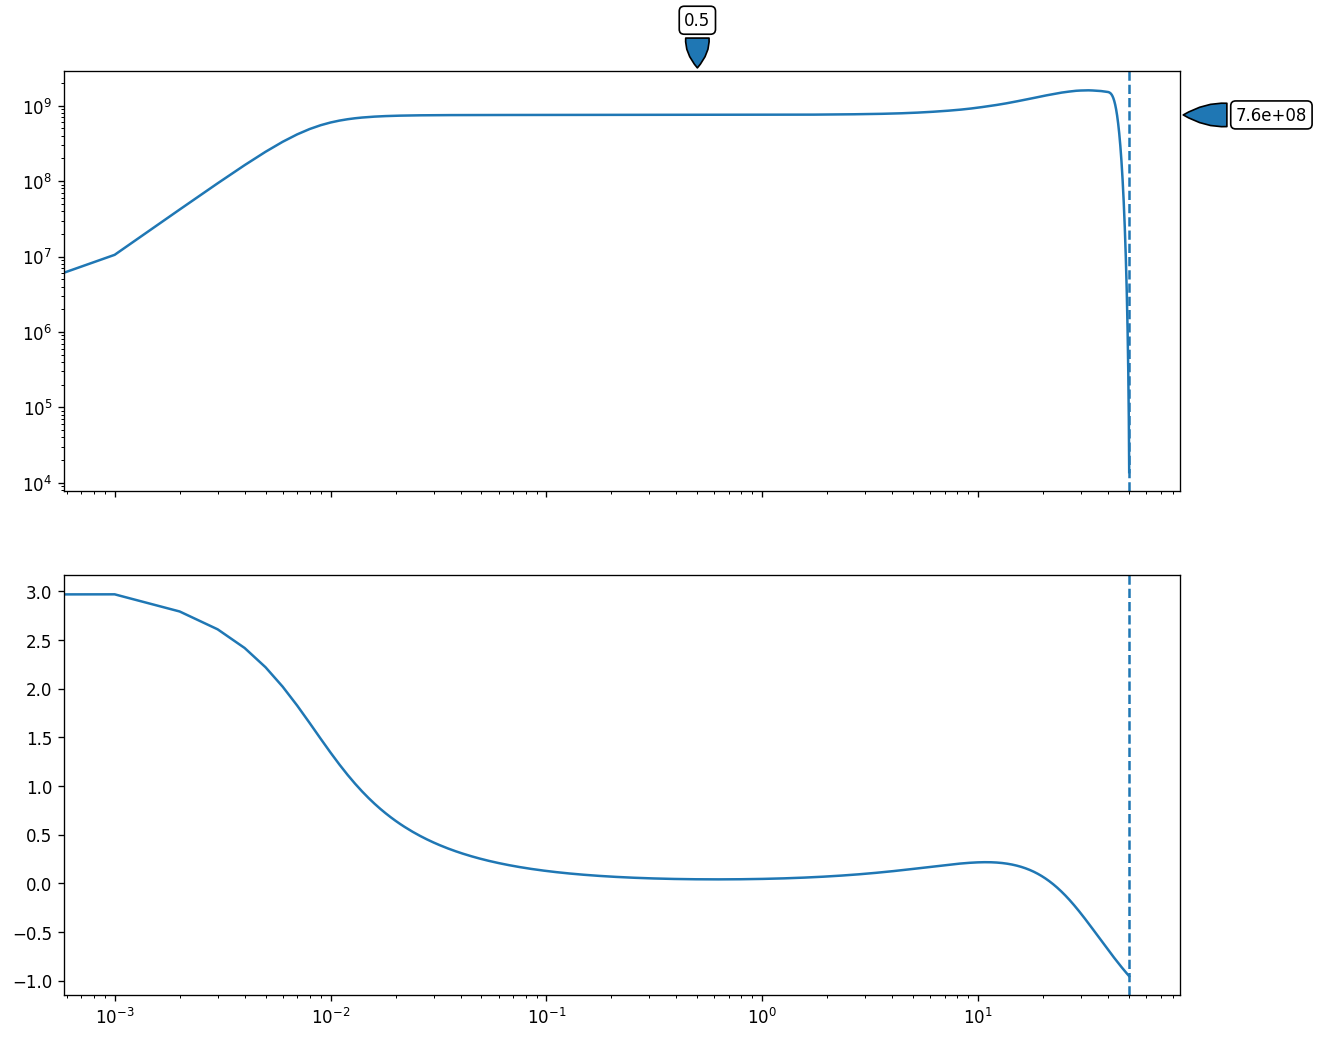

<Figure size 640x480 with 0 Axes>


 Saved StationXML to: HV_JOKA_HHZ_response.xml


In [5]:
from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt


# ============================================================
# 1. Load 1-day waveform
# ============================================================

t1 = UTCDateTime("2018-04-28T00:00:00")
t2 = t1 + 86400  # 24 hours

mseed_file = "/Users/christinaw/waveforms/Kilauea/HV_JOKA_*HZ/HV.JOKA.HHZ.2018-04-28.mseed"

print("\n=== Reading Waveform ===")
st = read(mseed_file, starttime=t1, endtime=t2)

print("\n=== Stream Metadata ===")
print(st)

print("\n=== Gap Report ===")
st.print_gaps()

# Use the first trace for reference sample rate
tr = st[0]
waveform_sampling_rate = tr.stats.sampling_rate
print(f"\nDetected waveform sampling rate: {waveform_sampling_rate} Hz")


# ============================================================
# 2. Download full StationXML metadata (sensor + datalogger + response)
# ============================================================

client = Client("IRIS")

network = "HV"
station = "JOKA"
location = "*"
channel = "*HZ"

print("\nDownloading full StationXML metadata...")
inventory = client.get_stations(
    network=network,
    station=station,
    location=location,
    channel=channel,
    starttime=t1,
    endtime=t2,
    level="response"
)

# ============================================================
# 3. Print FULL metadata (network → station → channel → sensor → datalogger)
# ============================================================

print("\n\n=============================")
print(" FULL STATION METADATA DUMP")
print("=============================\n")

for net in inventory:
    print(f"\n--- Network: {net.code} ---")
    print(f"Description : {net.description}")
    print(f"Stations    : {len(net.stations)}")

    for sta in net.stations:
        print("\n----------------------------------------")
        print(f"Station: {sta.code}")
        print(f"  Latitude     : {sta.latitude}")
        print(f"  Longitude    : {sta.longitude}")
        print(f"  Elevation    : {sta.elevation} m")
        print(f"  Start Date   : {sta.start_date}")
        print(f"  End Date     : {sta.end_date}")

        for cha in sta.channels:
            print("\n  ---- Channel ----")
            print(f"    Code        : {cha.code}")
            print(f"    Location    : {cha.location_code}")
            print(f"    Depth       : {cha.depth} m")
            print(f"    Azimuth     : {cha.azimuth}")
            print(f"    Dip         : {cha.dip}")
            print(f"    Sample Rate : {cha.sample_rate} Hz")
            print(f"    Start       : {cha.start_date}")
            print(f"    End         : {cha.end_date}")

            # -------------------------
            # Sensor block
            # -------------------------
            sens = cha.sensor
            if sens:
                print("\n    --- Sensor ---")
                print(f"      Type          : {sens.type}")
                print(f"      Description   : {sens.description}")
                print(f"      Manufacturer  : {sens.manufacturer}")
                print(f"      Model         : {sens.model}")
                print(f"      Serial Number : {sens.serial_number}")

            # -------------------------
            # Datalogger block
            # -------------------------
            dig = cha.data_logger
            if dig:
                print("\n    --- Data Logger ---")
                print(f"      Type          : {dig.type}")
                print(f"      Description   : {dig.description}")
                print(f"      Manufacturer  : {dig.manufacturer}")
                print(f"      Model         : {dig.model}")
                print(f"      Serial Number : {dig.serial_number}")
                print("      Gain          : (gain appears in response stages)")

            # -------------------------
            # Response Stages
            # -------------------------
            print("\n    --- Response Stages ---")

            for i, stage in enumerate(cha.response.response_stages, start=1):
                print(f"\n      Stage {i}: {stage.__class__.__name__}")

                # SAFE Stage Gain handling: float OR Gain object
                stage_gain = getattr(stage, "stage_gain", None)
                if stage_gain is not None:
                    if hasattr(stage_gain, "value"):  # Gain object
                        print(f"        Stage Gain : {stage_gain.value} {stage_gain.unit}")
                    else:  # float
                        print(f"        Stage Gain : {stage_gain} (unit unknown)")

                print(stage)


# ============================================================
# 4. Extract & Plot Instrument Response
# ============================================================

resp_id = f"{network}.{station}.{cha.location_code}.{cha.code}"
response = inventory.get_response(resp_id, t1)

print("\n=== Response Summary ===")
print(response)

# ------------------------------------------------------------
# AUTO-DETECT instrument bandwidth
# ------------------------------------------------------------
instrument_fs = cha.sample_rate                   # sample rate from metadata
instrument_nyquist = instrument_fs / 2.0

print("\n=== Instrument Bandwidth ===")
print(f"Instrument sample rate: {instrument_fs} Hz")
print(f"Nyquist: {instrument_nyquist} Hz")

# ------------------------------------------------------------
# Plotting with auto Nyquist
# ------------------------------------------------------------
print("\n=== Plotting Instrument Response (Velocity) ===")

import warnings
warnings.filterwarnings("ignore", message="No artists with labels found")

#response.plot(
#    min_freq=0.001,
#    output="VEL",
#    sampling_rate=instrument_fs   # auto Nyquist control
#)

# ------------------------------------------------------------
# Create a larger figure for the instrument response
# ------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(12, 10),      # <-- increase size here
    dpi=120,               # <-- high resolution
    sharex=True
)

# Now pass these axes to response.plot
response.plot(
    min_freq=0.001,
    output="VEL",
    sampling_rate=instrument_fs,
    axes=(ax1, ax2)        # <-- override default small figure
)

plt.tight_layout()
plt.show()

# You can also:
# response.plot(0.001, output="DISP", sampling_rate=instrument_fs)
# response.plot(0.001, output="ACC",  sampling_rate=instrument_fs)


# ============================================================
# 5. Save StationXML
# ============================================================

resp_filename = f"{network}_{station}_{cha.code}_response.xml"
inventory.write(resp_filename, format="STATIONXML")

print(f"\n Saved StationXML to: {resp_filename}")


1 Trace(s) in Stream:
HV.JOKA..HHZ | 2018-04-28T00:00:00.000000Z - 2018-04-30T00:00:00.000000Z | 100.0 Hz, 17280001 samples

=== Gap / Overlap Report ===
No gaps or overlaps detected.

Merging and interpolating gaps…

=== Trace Statistics ===
HV.JOKA..HHZ | 2018-04-28T00:00:00.000000Z - 2018-04-30T00:00:00.000000Z | 100.0 Hz, 17280001 samples
Removed response → VEL

=== Processed Trace Diagnostics ===
Trace ID: HV.JOKA..HHZ
Start time: 2018-04-28T00:00:00.000000Z
End time: 2018-04-30T00:00:00.000000Z
Npts: 17280001
Sampling rate: 100.0
Data type: float64


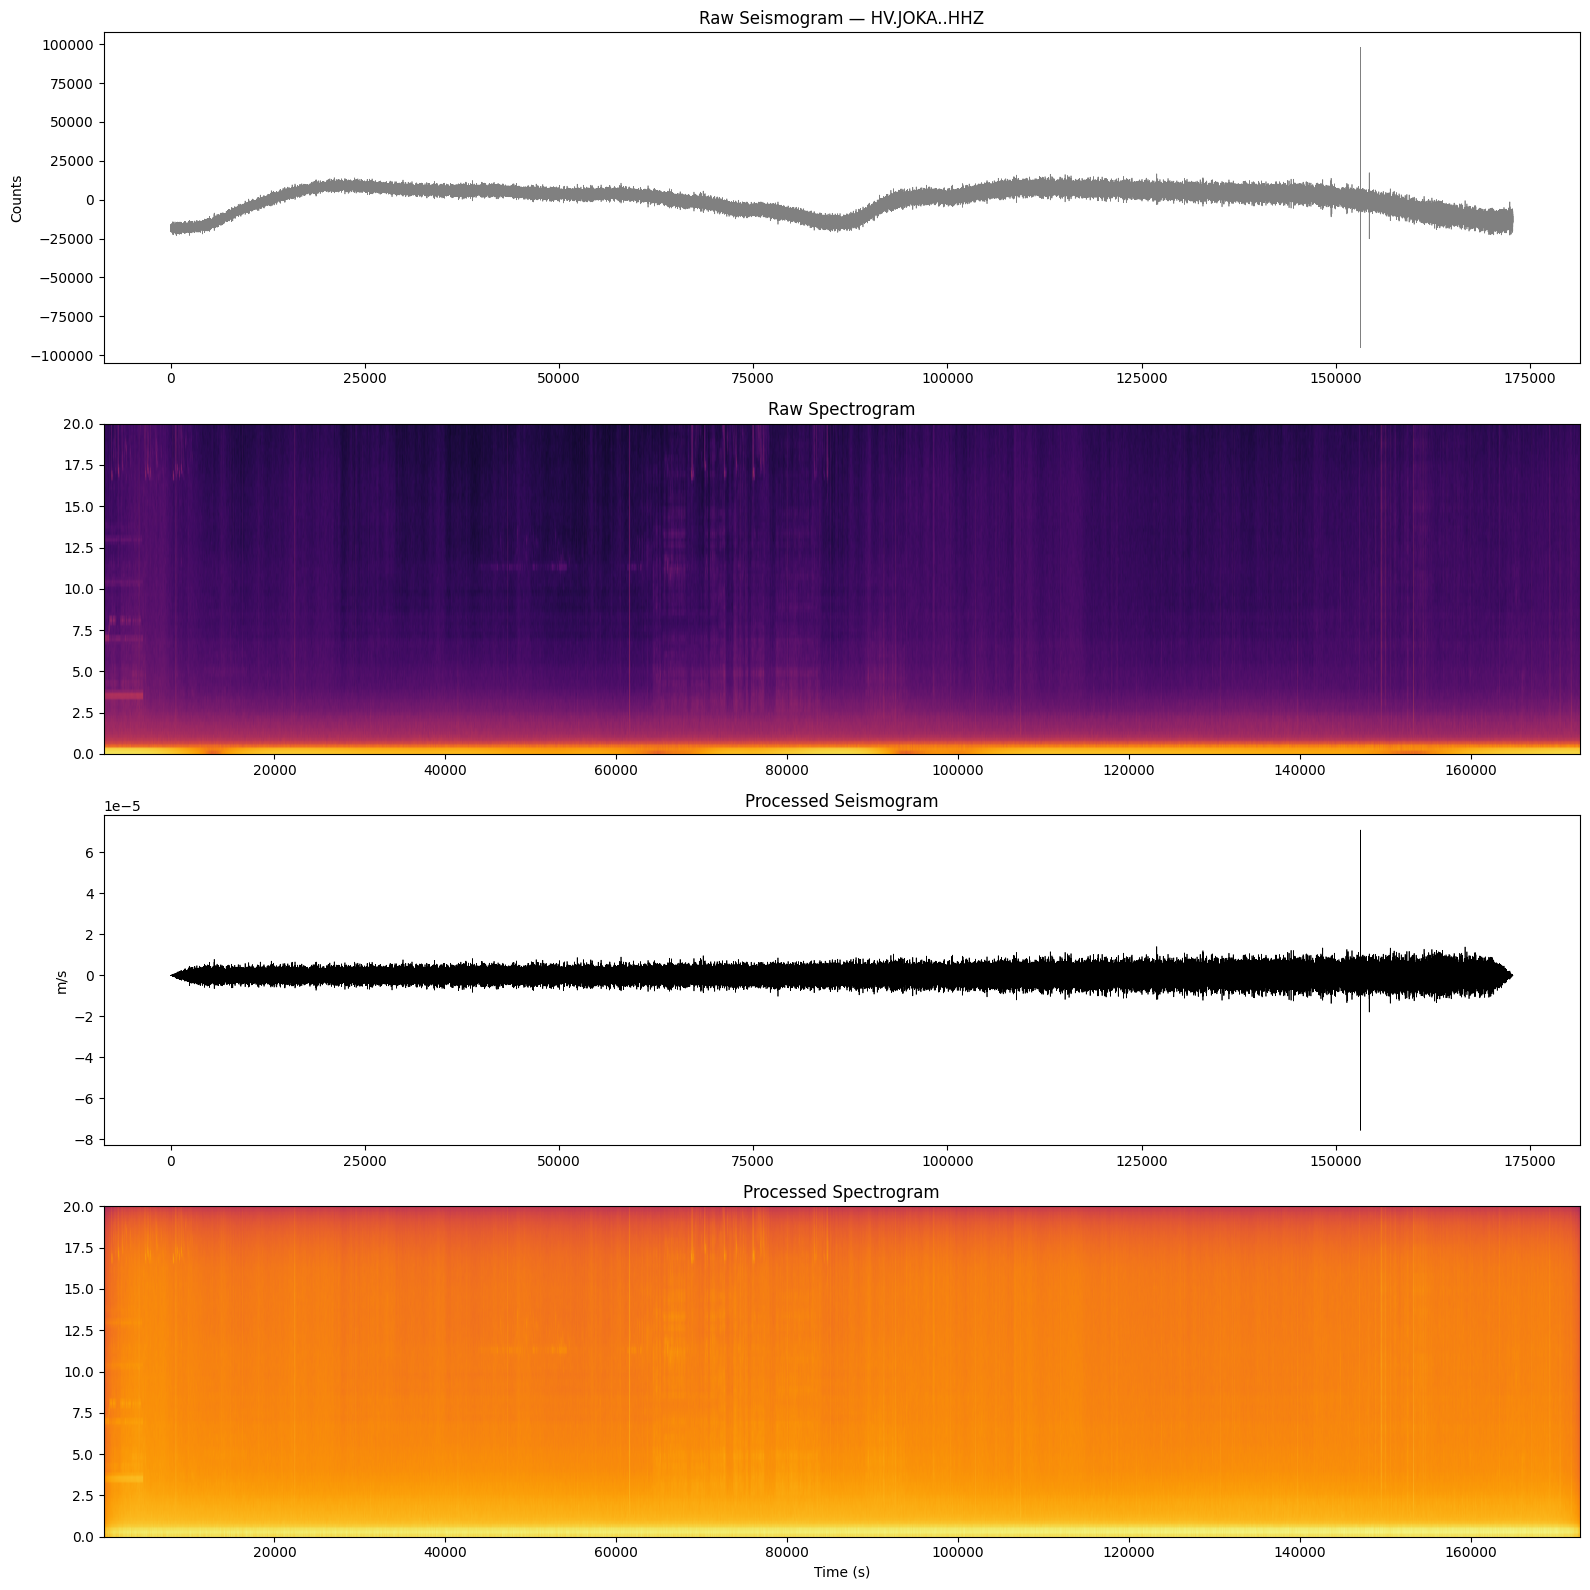

/Users/christinaw/anaconda3/envs/obspy/lib/python3.10/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)



Saved preconditioned file → /Users/christinaw/waveforms/Kilauea/preconditioned_HV.JOKA.HHZ.2018-04-28.mseed


In [18]:
#!/usr/bin/env python3
# ============================================================
# precondition.py — waveform preconditioning + diagnostics
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime, Stream
from obspy.core.trace import Trace
from obspy.clients.fdsn import Client


# ============================================================
# --- 1. SCAN FOR GAPS / OVERLAPS ---
# ============================================================
def detect_gaps_and_overlaps(stream):
    """
    Scan a Stream for gaps and overlaps and return a structured report.
    Works for continuous or multi-trace waveform segments.
    """
    gaps = stream.get_gaps()  # ObsPy built-in

    report = []

    print("\n===============================")
    print(" GAP / OVERLAP SCAN REPORT")
    print("===============================\n")

    if len(gaps) == 0:
        print("No gaps or overlaps detected.")
        return report

    for g in gaps:
        net, sta, loc, cha, start, end, samp, delta = g
        start = UTCDateTime(start)
        end = UTCDateTime(end)

        entry = {
            "id": f"{net}.{sta}.{loc}.{cha}",
            "start": str(start),
            "end": str(end),
            "duration_sec": delta,
            "type": "GAP" if delta > 0 else "OVERLAP"
        }
        report.append(entry)

        # Print formatted summary
        if delta > 0:
            print(f"GAP     | {entry['id']} | {entry['start']} → {entry['end']} | "
                  f"{delta:.3f} s missing")
        else:
            print(f"OVERLAP | {entry['id']} | {entry['start']} → {entry['end']} | "
                  f"{delta:.3f} s overlap")

    print("\nDetected:", len(report), "gap/overlap event(s)\n")
    return report


# ============================================================
# --- 2–8. STANDARD PRECONDITION FUNCTIONS ---
# ============================================================
def merge_and_fill(stream, method=1, fill_value='interpolate'):
    print("\nMerging and interpolating gaps…")
    stream.merge(method=1, fill_value='interpolate')
    return stream


def detrend_and_demean(trace):
    trace.detrend("linear")
    trace.detrend("demean")
    return trace


def remove_response_safe(trace, inventory=None, output="VEL",
                         pre_filt=(0.01, 0.02, 15, 20)):
    if inventory is None:
        print("No inventory — skipping response removal.")
        return trace
    try:
        trace.remove_response(inventory=inventory, output=output,
                              pre_filt=pre_filt, zero_mean=True, taper=True)
        print(f"Removed response → {output}")
    except Exception as e:
        print("Response removal failed:", e)
    return trace


def standardize_sampling(trace, target_sr=None):
    if target_sr is None:
        return trace
    current_sr = trace.stats.sampling_rate
    if abs(current_sr - target_sr) > 1e-6:
        trace.resample(target_sr)
        print(f"Resampled {trace.id}: {current_sr} → {target_sr} Hz")
    return trace


def bandpass_trace(trace, freqmin=0.1, freqmax=20.0):
    trace.filter("bandpass", freqmin=freqmin, freqmax=freqmax,
                 corners=4, zerophase=True)
    return trace


def spectral_whiten(trace):
    data = trace.data.astype(float)
    nfft = 1 << (len(data) - 1).bit_length()
    spec = np.fft.rfft(data, n=nfft)
    amp = np.abs(spec)
    amp[amp == 0] = 1e-20
    trace.data = np.fft.irfft(spec / amp, n=nfft)[:len(data)]
    return trace


# ============================================================
# --- 9. MAIN PRECONDITION WRAPPER ---
# ============================================================
def precondition_trace(trace,
                       inventory=None,
                       remove_resp=False,
                       resp_output="VEL",
                       resp_prefilt=(0.01, 0.02, 15, 20),
                       target_sr=None,
                       freqmin=0.1,
                       freqmax=20.0,
                       whiten=False):

    tr = trace.copy()
    tr = detrend_and_demean(tr)

    if remove_resp and inventory is not None:
        tr = remove_response_safe(tr, inventory=inventory,
                                  output=resp_output, pre_filt=resp_prefilt)

    tr = standardize_sampling(tr, target_sr)
    tr = bandpass_trace(tr, freqmin, freqmax)

    if whiten:
        tr = spectral_whiten(tr)

    diag = {
        "Trace ID": tr.id,
        "Start time": str(tr.stats.starttime),
        "End time": str(tr.stats.endtime),
        "Npts": tr.stats.npts,
        "Sampling rate": tr.stats.sampling_rate,
        "Data type": str(tr.data.dtype)
    }

    return tr, diag


# ============================================================
# --- 10. SEISMOGRAM + SPECTROGRAM PLOTS ---
# ============================================================
def plot_seismogram_and_spectrogram(trace_before, trace_after, freqmax=20.0):
    sr = trace_before.stats.sampling_rate
    t1 = np.arange(trace_before.stats.npts) / sr

    sr2 = trace_after.stats.sampling_rate
    t2 = np.arange(trace_after.stats.npts) / sr2

    fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=False)

    # Raw seismogram
    axes[0].plot(t1, trace_before.data, lw=0.5, color='gray')
    axes[0].set_title(f"Raw Seismogram — {trace_before.id}")
    axes[0].set_ylabel("Counts")

    # Raw spectrogram
    axes[1].specgram(trace_before.data, NFFT=512, Fs=sr,
                     noverlap=384, cmap="inferno", vmin=-20, vmax=100)
    axes[1].set_title("Raw Spectrogram")
    axes[1].set_ylim(0, freqmax)

    # Processed seismogram
    axes[2].plot(t2, trace_after.data, lw=0.5, color='black')
    axes[2].set_title("Processed Seismogram")
    axes[2].set_ylabel("m/s")

    # Processed spectrogram
    axes[3].specgram(trace_after.data, NFFT=512, Fs=sr2,
                     noverlap=384, cmap="inferno", scale="dB", mode="psd")
    axes[3].set_title("Processed Spectrogram")
    axes[3].set_ylim(0, freqmax)
    axes[3].set_xlabel("Time (s)")

    plt.tight_layout()
    plt.show()


# ============================================================
# --- 11. MAIN EXECUTION EXAMPLE ---
# ============================================================
if __name__ == "__main__":

    wavefile = "/Users/christinaw/waveforms/Kilauea/HV_JOKA_*HZ/HV.JOKA.HHZ.2018-04-28.mseed"
    st = read(wavefile)
    print(st)

    # Statistics: gaps/overlaps
    gaps = scan_gaps(st)

    # Merge
    st = merge_and_fill(st)

    # Inventory
    client = Client("IRIS")
    inv = client.get_stations(network=st[0].stats.network,
                              station=st[0].stats.station,
                              location=st[0].stats.location,
                              channel=st[0].stats.channel,
                              level="response")

    out_stream = Stream()

    # Process each trace
    for tr in st:
        print("\n=== Trace Statistics ===")
        print(tr)

        tr_proc, diag = precondition_trace(
            tr,
            inventory=inv,
            remove_resp=True,
            freqmin=0.1, freqmax=20.0,
            whiten=False
        )

        # Print clean statistics block
        print("\n=== Processed Trace Diagnostics ===")
        for k, v in diag.items():
            print(f"{k}: {v}")

        out_stream += tr_proc

        plot_seismogram_and_spectrogram(tr, tr_proc)

    out_file = "/Users/christinaw/waveforms/Kilauea/preconditioned_HV.JOKA.HHZ.2018-04-28.mseed"
    out_stream.write(out_file, format="MSEED")
    print(f"\nSaved preconditioned file → {out_file}")


1 Trace(s) in Stream:
HV.KUPD..EHZ | 2018-04-28T00:00:00.005000Z - 2018-04-29T23:59:59.995000Z | 100.0 Hz, 17280000 samples

 GAP / OVERLAP SCAN REPORT

No gaps or overlaps detected.

Merging and interpolating gaps…

=== Trace Statistics ===
HV.KUPD..EHZ | 2018-04-28T00:00:00.005000Z - 2018-04-29T23:59:59.995000Z | 100.0 Hz, 17280000 samples
Removed response → VEL

=== Processed Trace Diagnostics ===
Trace ID: HV.KUPD..EHZ
Start time: 2018-04-28T00:00:00.005000Z
End time: 2018-04-29T23:59:59.995000Z
Npts: 17280000
Sampling rate: 100.0
Data type: float64


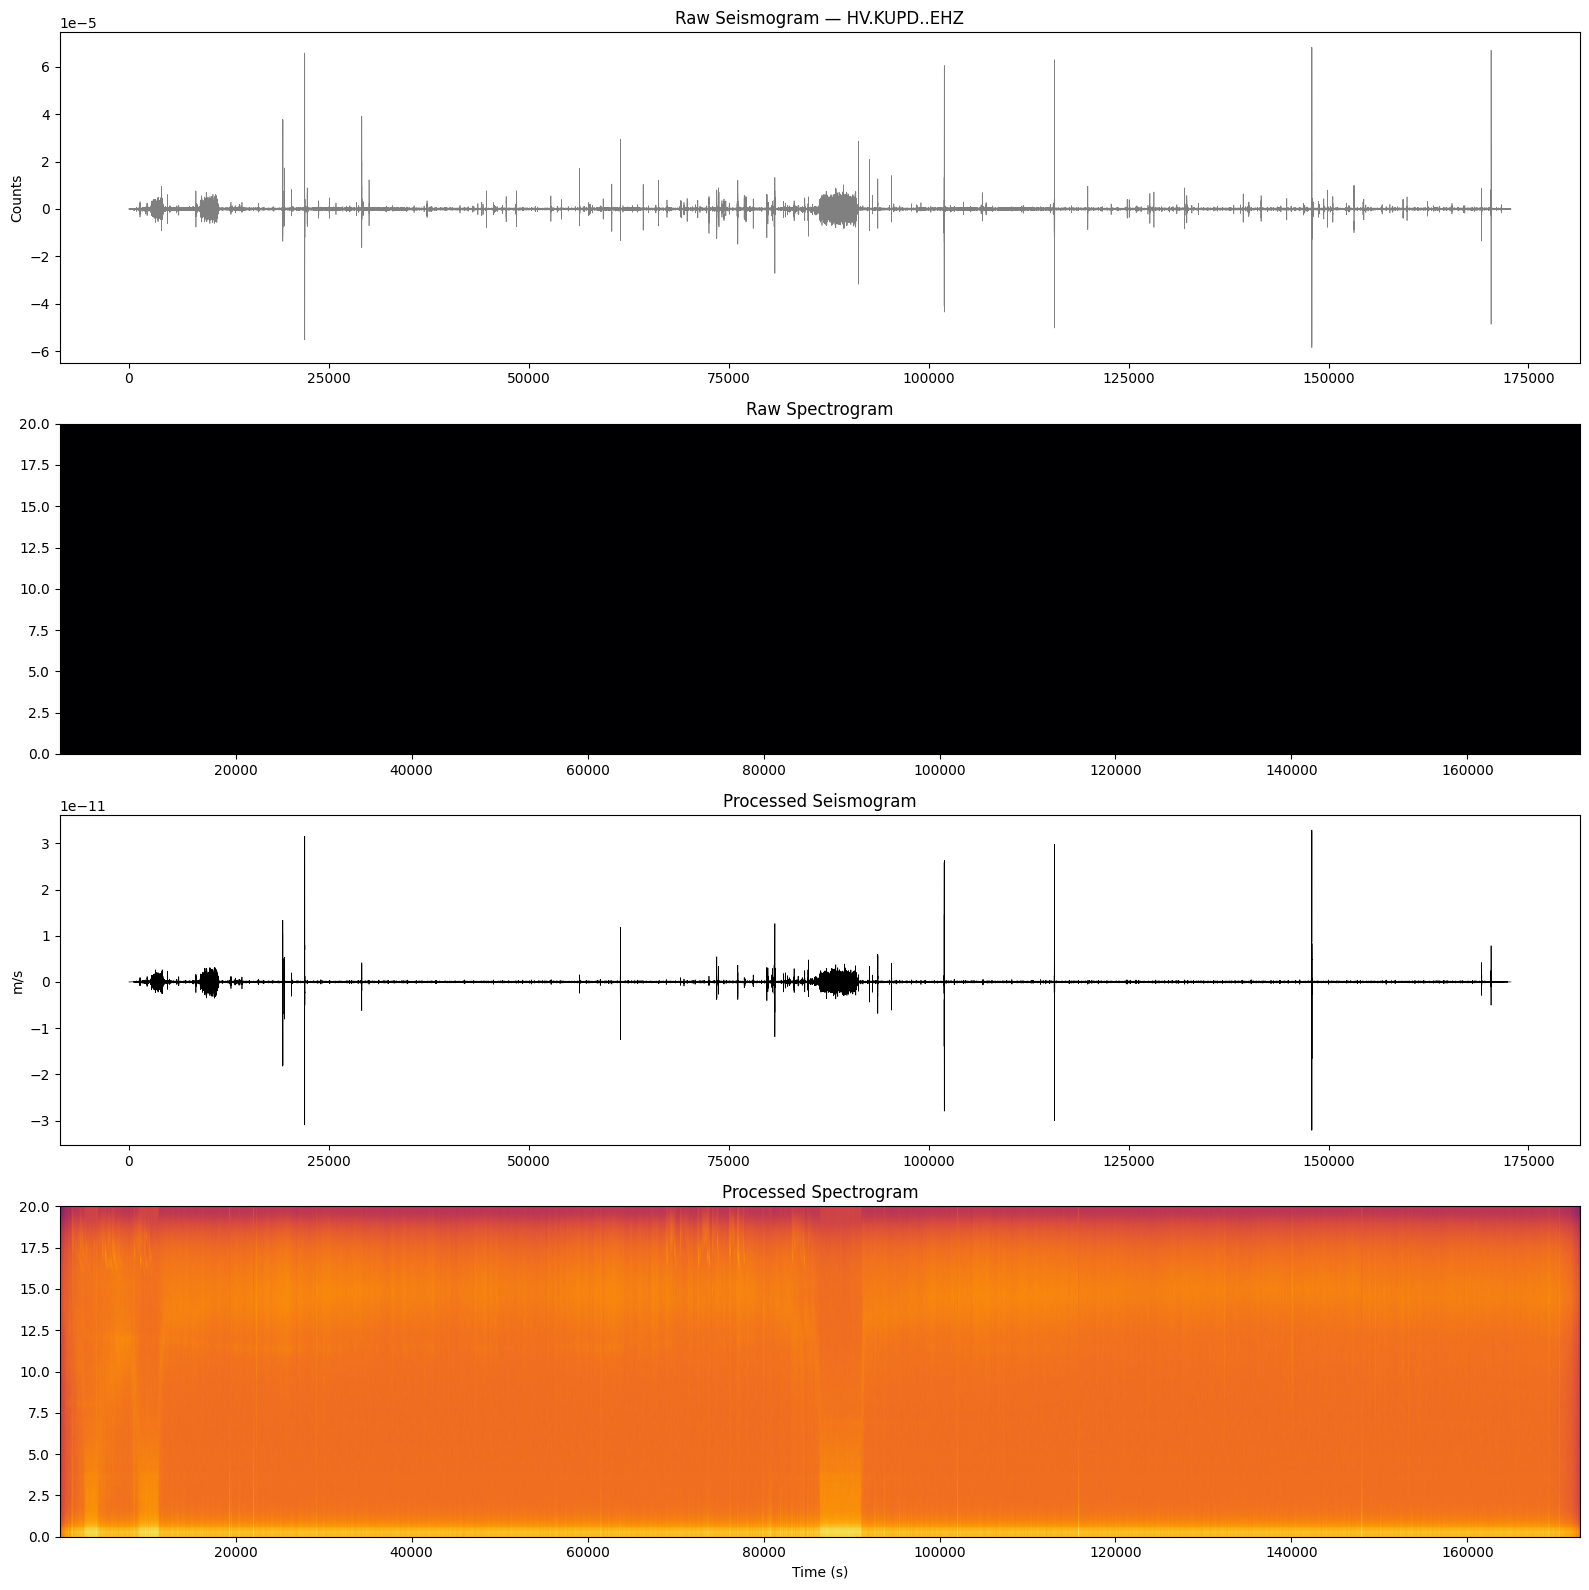


Saved preconditioned file → /Users/christinaw/waveforms/Kilauea/preconditioned_HV.KUPD.HHZ.2018-04-28.mseed


In [40]:
#!/usr/bin/env python3
# ============================================================
# precondition.py — waveform preconditioning + diagnostics
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime, Stream
from obspy.core.trace import Trace
from obspy.clients.fdsn import Client


# ============================================================
# --- 1. SCAN FOR GAPS / OVERLAPS ---
# ============================================================
def detect_gaps_and_overlaps(stream):
    """
    Scan a Stream for gaps and overlaps and return a structured report.
    Works for continuous or multi-trace waveform segments.
    """
    # Statistics: gaps/overlaps
    gaps = stream.get_gaps()   # ObsPy built-in

    report = []

    print("\n===============================")
    print(" GAP / OVERLAP SCAN REPORT")
    print("===============================\n")

    if len(gaps) == 0:
        print("No gaps or overlaps detected.")
        return report

    for g in gaps:
        net, sta, loc, cha, start, end, samp, delta = g
        start = UTCDateTime(start)
        end = UTCDateTime(end)

        entry = {
            "id": f"{net}.{sta}.{loc}.{cha}",
            "start": str(start),
            "end": str(end),
            "duration_sec": delta,
            "type": "GAP" if delta > 0 else "OVERLAP"
        }
        report.append(entry)

        # Print formatted summary
        if delta > 0:
            print(f"GAP     | {entry['id']} | {entry['start']} → {entry['end']} | "
                  f"{delta:.3f} s missing")
        else:
            print(f"OVERLAP | {entry['id']} | {entry['start']} → {entry['end']} | "
                  f"{delta:.3f} s overlap")

    print("\nDetected:", len(report), "gap/overlap event(s)\n")
    return report


# ============================================================
# --- 2–8. STANDARD PRECONDITION FUNCTIONS ---
# ============================================================
def merge_and_fill(stream, method=1, fill_value='interpolate'):
    print("\nMerging and interpolating gaps…")
    stream.merge(method=1, fill_value='interpolate')
    return stream


def detrend_and_demean(trace):
    trace.detrend("linear")
    trace.detrend("demean")
    return trace


def remove_response_safe(trace, inventory=None, output="VEL",
                         pre_filt=(0.01, 0.02, 15, 20)):
    if inventory is None:
        print("No inventory — skipping response removal.")
        return trace
    try:
        trace.remove_response(inventory=inventory, output=output,
                              pre_filt=pre_filt, zero_mean=True, taper=True)
        print(f"Removed response → {output}")
    except Exception as e:
        print("Response removal failed:", e)
    return trace


def standardize_sampling(trace, target_sr=None):
    if target_sr is None:
        return trace
    current_sr = trace.stats.sampling_rate
    if abs(current_sr - target_sr) > 1e-6:
        trace.resample(target_sr)
        print(f"Resampled {trace.id}: {current_sr} → {target_sr} Hz")
    return trace


def bandpass_trace(trace, freqmin=0.1, freqmax=20.0):
    trace.filter("bandpass", freqmin=freqmin, freqmax=freqmax,
                 corners=4, zerophase=True)
    return trace


def spectral_whiten(trace):
    data = trace.data.astype(float)
    nfft = 1 << (len(data) - 1).bit_length()
    spec = np.fft.rfft(data, n=nfft)
    amp = np.abs(spec)
    amp[amp == 0] = 1e-20
    trace.data = np.fft.irfft(spec / amp, n=nfft)[:len(data)]
    return trace


# ============================================================
# --- 9. MAIN PRECONDITION WRAPPER ---
# ============================================================
def precondition_trace(trace,
                       inventory=None,
                       remove_resp=False,
                       resp_output="VEL",
                       resp_prefilt=(0.01, 0.02, 15, 20),
                       target_sr=None,
                       freqmin=0.1,
                       freqmax=20.0,
                       whiten=False):

    tr = trace.copy()
    tr = detrend_and_demean(tr)

    if remove_resp and inventory is not None:
        tr = remove_response_safe(tr, inventory=inventory,
                                  output=resp_output, pre_filt=resp_prefilt)

    tr = standardize_sampling(tr, target_sr)
    tr = bandpass_trace(tr, freqmin, freqmax)

    if whiten:
        tr = spectral_whiten(tr)

    diag = {
        "Trace ID": tr.id,
        "Start time": str(tr.stats.starttime),
        "End time": str(tr.stats.endtime),
        "Npts": tr.stats.npts,
        "Sampling rate": tr.stats.sampling_rate,
        "Data type": str(tr.data.dtype)
    }

    return tr, diag


# ============================================================
# --- 10. SEISMOGRAM + SPECTROGRAM PLOTS ---
# ============================================================
def plot_seismogram_and_spectrogram(trace_before, trace_after, freqmax=20.0):
    sr = trace_before.stats.sampling_rate
    t1 = np.arange(trace_before.stats.npts) / sr

    sr2 = trace_after.stats.sampling_rate
    t2 = np.arange(trace_after.stats.npts) / sr2

    fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=False)

    # Raw seismogram
    axes[0].plot(t1, trace_before.data, lw=0.5, color='gray')
    axes[0].set_title(f"Raw Seismogram — {trace_before.id}")
    axes[0].set_ylabel("Counts")

    # Raw spectrogram
    axes[1].specgram(trace_before.data, NFFT=512, Fs=sr,
                     noverlap=384, cmap="inferno", vmin=-20, vmax=100)
    axes[1].set_title("Raw Spectrogram")
    axes[1].set_ylim(0, freqmax)

    # Processed seismogram
    axes[2].plot(t2, trace_after.data, lw=0.5, color='black')
    axes[2].set_title("Processed Seismogram")
    axes[2].set_ylabel("m/s")

    # Processed spectrogram
    axes[3].specgram(trace_after.data, NFFT=512, Fs=sr2,
                     noverlap=384, cmap="inferno", scale="dB", mode="psd")
    axes[3].set_title("Processed Spectrogram")
    axes[3].set_ylim(0, freqmax)
    axes[3].set_xlabel("Time (s)")

    plt.tight_layout()
    plt.show()


# ============================================================
# --- 11. MAIN EXECUTION EXAMPLE ---
# ============================================================
if __name__ == "__main__":

    wavefile = "/Users/christinaw/waveforms/Kilauea/HV_KUPD_*HZ/HV.KUPD.EHZ.2018-04-28.mseed"
    st = read(wavefile)
    print(st)

    # Statistics: gaps/overlaps
    gaps = detect_gaps_and_overlaps(st)


    # Merge
    st = merge_and_fill(st)

    # Inventory
    client = Client("IRIS")
    inv = client.get_stations(network=st[0].stats.network,
                              station=st[0].stats.station,
                              location=st[0].stats.location,
                              channel=st[0].stats.channel,
                              level="response")

    out_stream = Stream()

    # Process each trace
    for tr in st:
        print("\n=== Trace Statistics ===")
        print(tr)

        tr_proc, diag = precondition_trace(
            tr,
            inventory=inv,
            remove_resp=True,
            freqmin=0.1, freqmax=20.0,
            whiten=False
        )

        # Print clean statistics block
        print("\n=== Processed Trace Diagnostics ===")
        for k, v in diag.items():
            print(f"{k}: {v}")

        out_stream += tr_proc

        plot_seismogram_and_spectrogram(tr, tr_proc)

    out_file = "/Users/christinaw/waveforms/Kilauea/preconditioned_HV.KUPD.HHZ.2018-04-28.mseed"
    out_stream.write(out_file, format="MSEED")
    print(f"\nSaved preconditioned file → {out_file}")


1 Trace(s) in Stream:
HV.KLUD..EHZ | 2018-04-28T00:00:00.000000Z - 2018-04-30T00:00:00.000000Z | 100.0 Hz, 17280001 samples

 GAP / OVERLAP SCAN REPORT

No gaps or overlaps detected.

Merging and interpolating gaps…

=== Trace Statistics ===
HV.KLUD..EHZ | 2018-04-28T00:00:00.000000Z - 2018-04-30T00:00:00.000000Z | 100.0 Hz, 17280001 samples
Removed response → VEL

=== Processed Trace Diagnostics ===
Trace ID: HV.KLUD..EHZ
Start time: 2018-04-28T00:00:00.000000Z
End time: 2018-04-30T00:00:00.000000Z
Npts: 17280001
Sampling rate: 100.0
Data type: float64


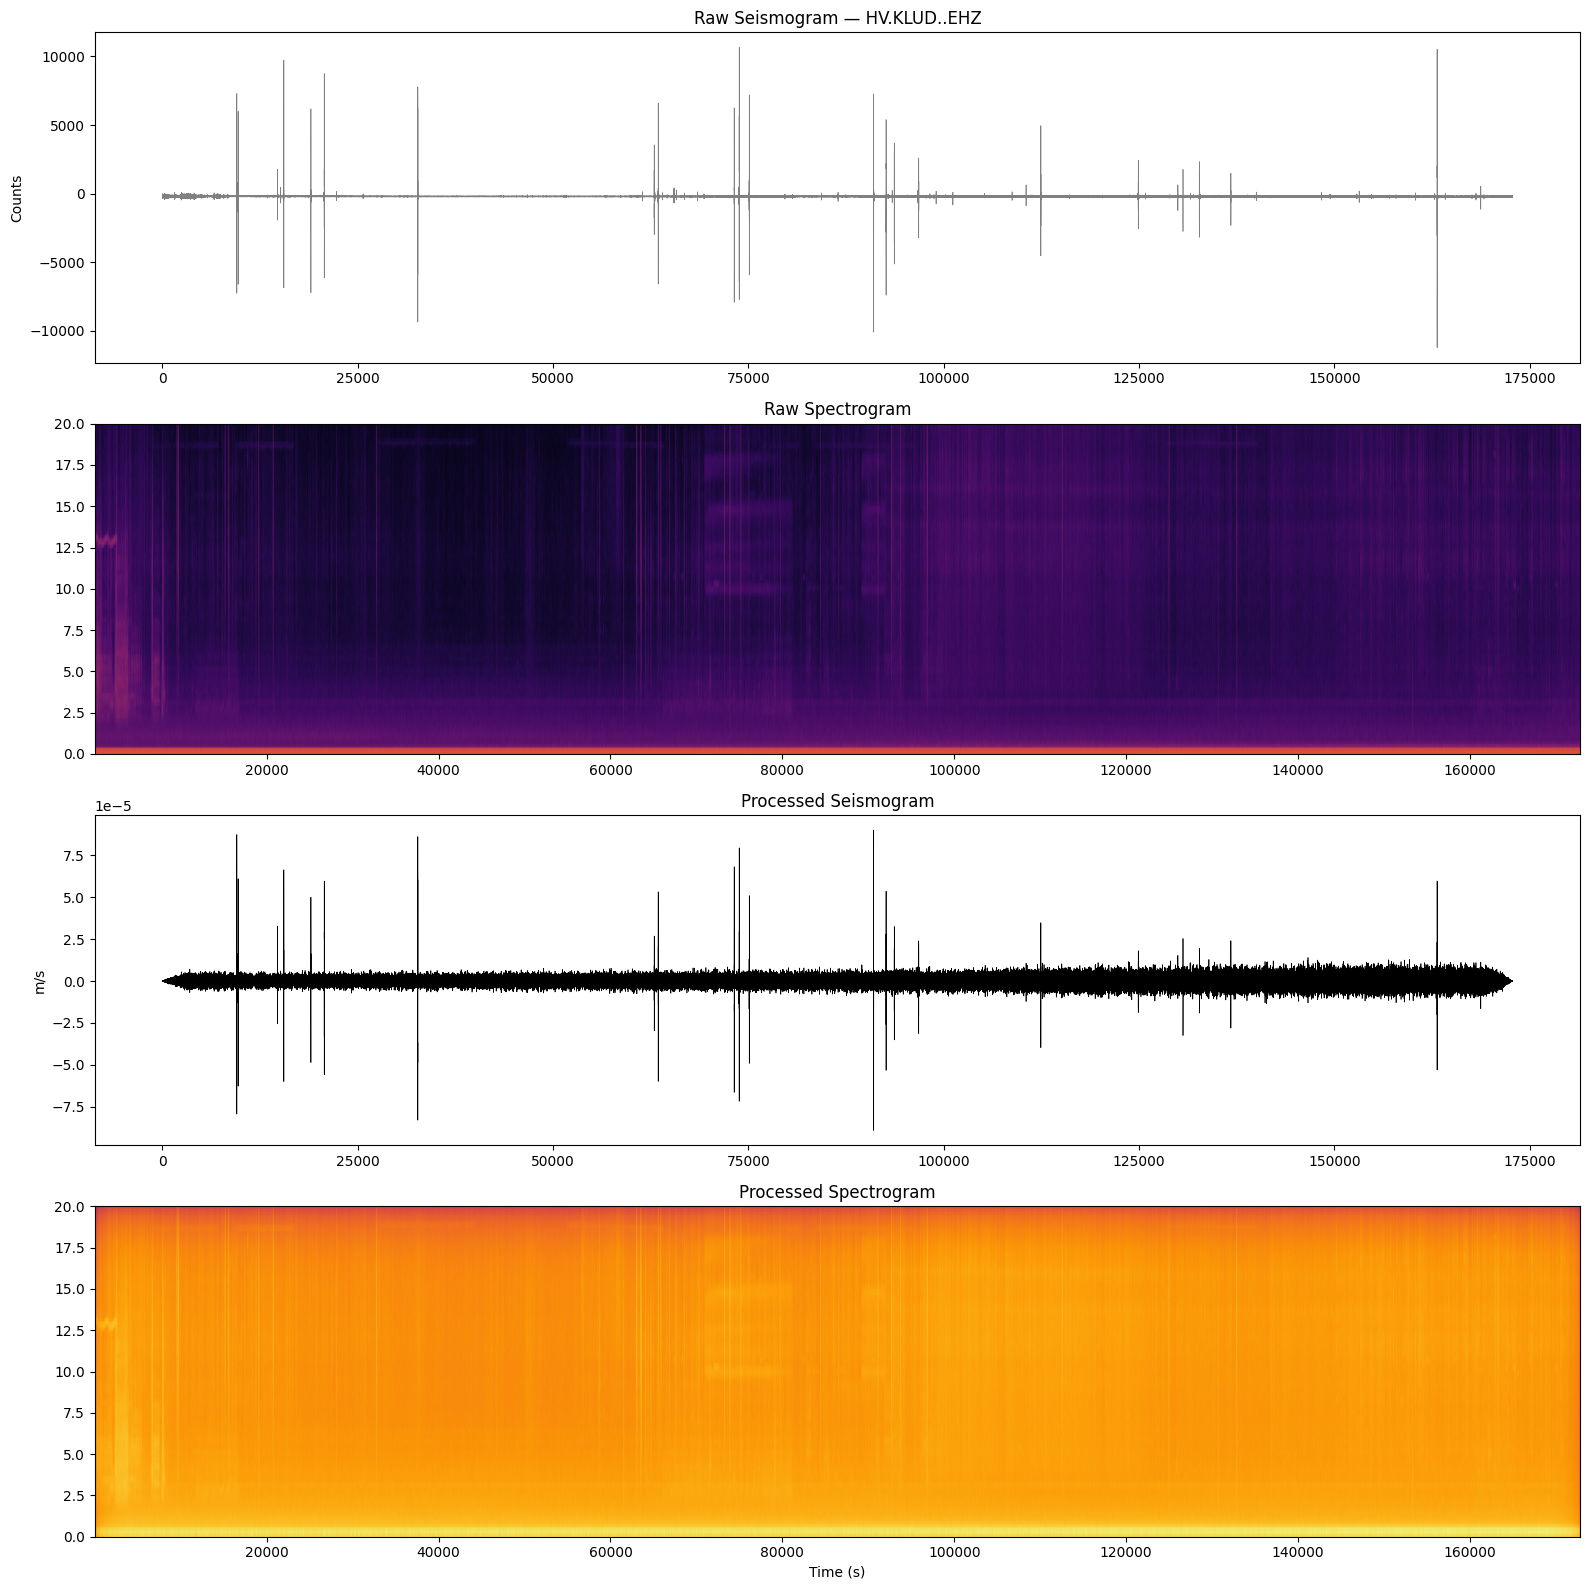

/Users/christinaw/anaconda3/envs/obspy/lib/python3.10/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)



Saved preconditioned file → /Users/christinaw/waveforms/Kilauea/preconditioned_HV.KUPD.HHZ.2018-04-28.mseed


In [42]:
#!/usr/bin/env python3
# ============================================================
# precondition.py — waveform preconditioning + diagnostics
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime, Stream
from obspy.core.trace import Trace
from obspy.clients.fdsn import Client


# ============================================================
# --- 1. SCAN FOR GAPS / OVERLAPS ---
# ============================================================
def detect_gaps_and_overlaps(stream):
    """
    Scan a Stream for gaps and overlaps and return a structured report.
    Works for continuous or multi-trace waveform segments.
    """
    # Statistics: gaps/overlaps
    gaps = stream.get_gaps()   # ObsPy built-in

    report = []

    print("\n===============================")
    print(" GAP / OVERLAP SCAN REPORT")
    print("===============================\n")

    if len(gaps) == 0:
        print("No gaps or overlaps detected.")
        return report

    for g in gaps:
        net, sta, loc, cha, start, end, samp, delta = g
        start = UTCDateTime(start)
        end = UTCDateTime(end)

        entry = {
            "id": f"{net}.{sta}.{loc}.{cha}",
            "start": str(start),
            "end": str(end),
            "duration_sec": delta,
            "type": "GAP" if delta > 0 else "OVERLAP"
        }
        report.append(entry)

        # Print formatted summary
        if delta > 0:
            print(f"GAP     | {entry['id']} | {entry['start']} → {entry['end']} | "
                  f"{delta:.3f} s missing")
        else:
            print(f"OVERLAP | {entry['id']} | {entry['start']} → {entry['end']} | "
                  f"{delta:.3f} s overlap")

    print("\nDetected:", len(report), "gap/overlap event(s)\n")
    return report


# ============================================================
# --- 2–8. STANDARD PRECONDITION FUNCTIONS ---
# ============================================================
def merge_and_fill(stream, method=1, fill_value='interpolate'):
    print("\nMerging and interpolating gaps…")
    stream.merge(method=1, fill_value='interpolate')
    return stream


def detrend_and_demean(trace):
    trace.detrend("linear")
    trace.detrend("demean")
    return trace


def remove_response_safe(trace, inventory=None, output="VEL",
                         pre_filt=(0.01, 0.02, 15, 20)):
    if inventory is None:
        print("No inventory — skipping response removal.")
        return trace
    try:
        trace.remove_response(inventory=inventory, output=output,
                              pre_filt=pre_filt, zero_mean=True, taper=True)
        print(f"Removed response → {output}")
    except Exception as e:
        print("Response removal failed:", e)
    return trace


def standardize_sampling(trace, target_sr=None):
    if target_sr is None:
        return trace
    current_sr = trace.stats.sampling_rate
    if abs(current_sr - target_sr) > 1e-6:
        trace.resample(target_sr)
        print(f"Resampled {trace.id}: {current_sr} → {target_sr} Hz")
    return trace


def bandpass_trace(trace, freqmin=0.1, freqmax=20.0):
    trace.filter("bandpass", freqmin=freqmin, freqmax=freqmax,
                 corners=4, zerophase=True)
    return trace


def spectral_whiten(trace):
    data = trace.data.astype(float)
    nfft = 1 << (len(data) - 1).bit_length()
    spec = np.fft.rfft(data, n=nfft)
    amp = np.abs(spec)
    amp[amp == 0] = 1e-20
    trace.data = np.fft.irfft(spec / amp, n=nfft)[:len(data)]
    return trace


# ============================================================
# --- 9. MAIN PRECONDITION WRAPPER ---
# ============================================================
def precondition_trace(trace,
                       inventory=None,
                       remove_resp=False,
                       resp_output="VEL",
                       resp_prefilt=(0.01, 0.02, 15, 20),
                       target_sr=None,
                       freqmin=0.1,
                       freqmax=20.0,
                       whiten=False):

    tr = trace.copy()
    tr = detrend_and_demean(tr)

    if remove_resp and inventory is not None:
        tr = remove_response_safe(tr, inventory=inventory,
                                  output=resp_output, pre_filt=resp_prefilt)

    tr = standardize_sampling(tr, target_sr)
    tr = bandpass_trace(tr, freqmin, freqmax)

    if whiten:
        tr = spectral_whiten(tr)

    diag = {
        "Trace ID": tr.id,
        "Start time": str(tr.stats.starttime),
        "End time": str(tr.stats.endtime),
        "Npts": tr.stats.npts,
        "Sampling rate": tr.stats.sampling_rate,
        "Data type": str(tr.data.dtype)
    }

    return tr, diag


# ============================================================
# --- 10. SEISMOGRAM + SPECTROGRAM PLOTS ---
# ============================================================
def plot_seismogram_and_spectrogram(trace_before, trace_after, freqmax=20.0):
    sr = trace_before.stats.sampling_rate
    t1 = np.arange(trace_before.stats.npts) / sr

    sr2 = trace_after.stats.sampling_rate
    t2 = np.arange(trace_after.stats.npts) / sr2

    fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=False)

    # Raw seismogram
    axes[0].plot(t1, trace_before.data, lw=0.5, color='gray')
    axes[0].set_title(f"Raw Seismogram — {trace_before.id}")
    axes[0].set_ylabel("Counts")

    # Raw spectrogram
    axes[1].specgram(trace_before.data, NFFT=512, Fs=sr,
                     noverlap=384, cmap="inferno", vmin=-20, vmax=100)
    axes[1].set_title("Raw Spectrogram")
    axes[1].set_ylim(0, freqmax)

    # Processed seismogram
    axes[2].plot(t2, trace_after.data, lw=0.5, color='black')
    axes[2].set_title("Processed Seismogram")
    axes[2].set_ylabel("m/s")

    # Processed spectrogram
    axes[3].specgram(trace_after.data, NFFT=512, Fs=sr2,
                     noverlap=384, cmap="inferno", scale="dB", mode="psd")
    axes[3].set_title("Processed Spectrogram")
    axes[3].set_ylim(0, freqmax)
    axes[3].set_xlabel("Time (s)")

    plt.tight_layout()
    plt.show()


# ============================================================
# --- 11. MAIN EXECUTION EXAMPLE ---
# ============================================================
if __name__ == "__main__":

    wavefile = "/Users/christinaw/waveforms/Kilauea/HV_KLUD_*HZ/HV.KLUD.HHZ.2018-04-28.mseed"
    st = read(wavefile)
    print(st)

    # Statistics: gaps/overlaps
    gaps = detect_gaps_and_overlaps(st)


    # Merge
    st = merge_and_fill(st)

    # Inventory
    client = Client("IRIS")
    inv = client.get_stations(network=st[0].stats.network,
                              station=st[0].stats.station,
                              location=st[0].stats.location,
                              channel=st[0].stats.channel,
                              level="response")

    out_stream = Stream()

    # Process each trace
    for tr in st:
        print("\n=== Trace Statistics ===")
        print(tr)

        tr_proc, diag = precondition_trace(
            tr,
            inventory=inv,
            remove_resp=True,
            freqmin=0.1, freqmax=20.0,
            whiten=False
        )

        # Print clean statistics block
        print("\n=== Processed Trace Diagnostics ===")
        for k, v in diag.items():
            print(f"{k}: {v}")

        out_stream += tr_proc

        plot_seismogram_and_spectrogram(tr, tr_proc)

    out_file = "/Users/christinaw/waveforms/Kilauea/preconditioned_HV.KUPD.HHZ.2018-04-28.mseed"
    out_stream.write(out_file, format="MSEED")
    print(f"\nSaved preconditioned file → {out_file}")



Reading waveform…

Processing → HV.JOKA.HHZ

✓ Saved merged RSAM+SSAM CSV
✓ Saved RSAM_0.1-0.5Hz → /Users/christinaw/waveforms/Kilauea/single_station_rsam_ssam_equal_bands/JOKA_RSAM_0.1-0.5Hz.csv
✓ Saved RSAM_0.5-1.0Hz → /Users/christinaw/waveforms/Kilauea/single_station_rsam_ssam_equal_bands/JOKA_RSAM_0.5-1.0Hz.csv
✓ Saved RSAM_1.0-4.0Hz → /Users/christinaw/waveforms/Kilauea/single_station_rsam_ssam_equal_bands/JOKA_RSAM_1.0-4.0Hz.csv
✓ Saved RSAM_4.0-8.0Hz → /Users/christinaw/waveforms/Kilauea/single_station_rsam_ssam_equal_bands/JOKA_RSAM_4.0-8.0Hz.csv
✓ Saved RSAM_8.0-16.0Hz → /Users/christinaw/waveforms/Kilauea/single_station_rsam_ssam_equal_bands/JOKA_RSAM_8.0-16.0Hz.csv
✓ Saved SSAM_0.1-0.5Hz → /Users/christinaw/waveforms/Kilauea/single_station_rsam_ssam_equal_bands/JOKA_SSAM_0.1-0.5Hz.csv
✓ Saved SSAM_0.5-1.0Hz → /Users/christinaw/waveforms/Kilauea/single_station_rsam_ssam_equal_bands/JOKA_SSAM_0.5-1.0Hz.csv
✓ Saved SSAM_1.0-4.0Hz → /Users/christinaw/waveforms/Kilauea/single_s

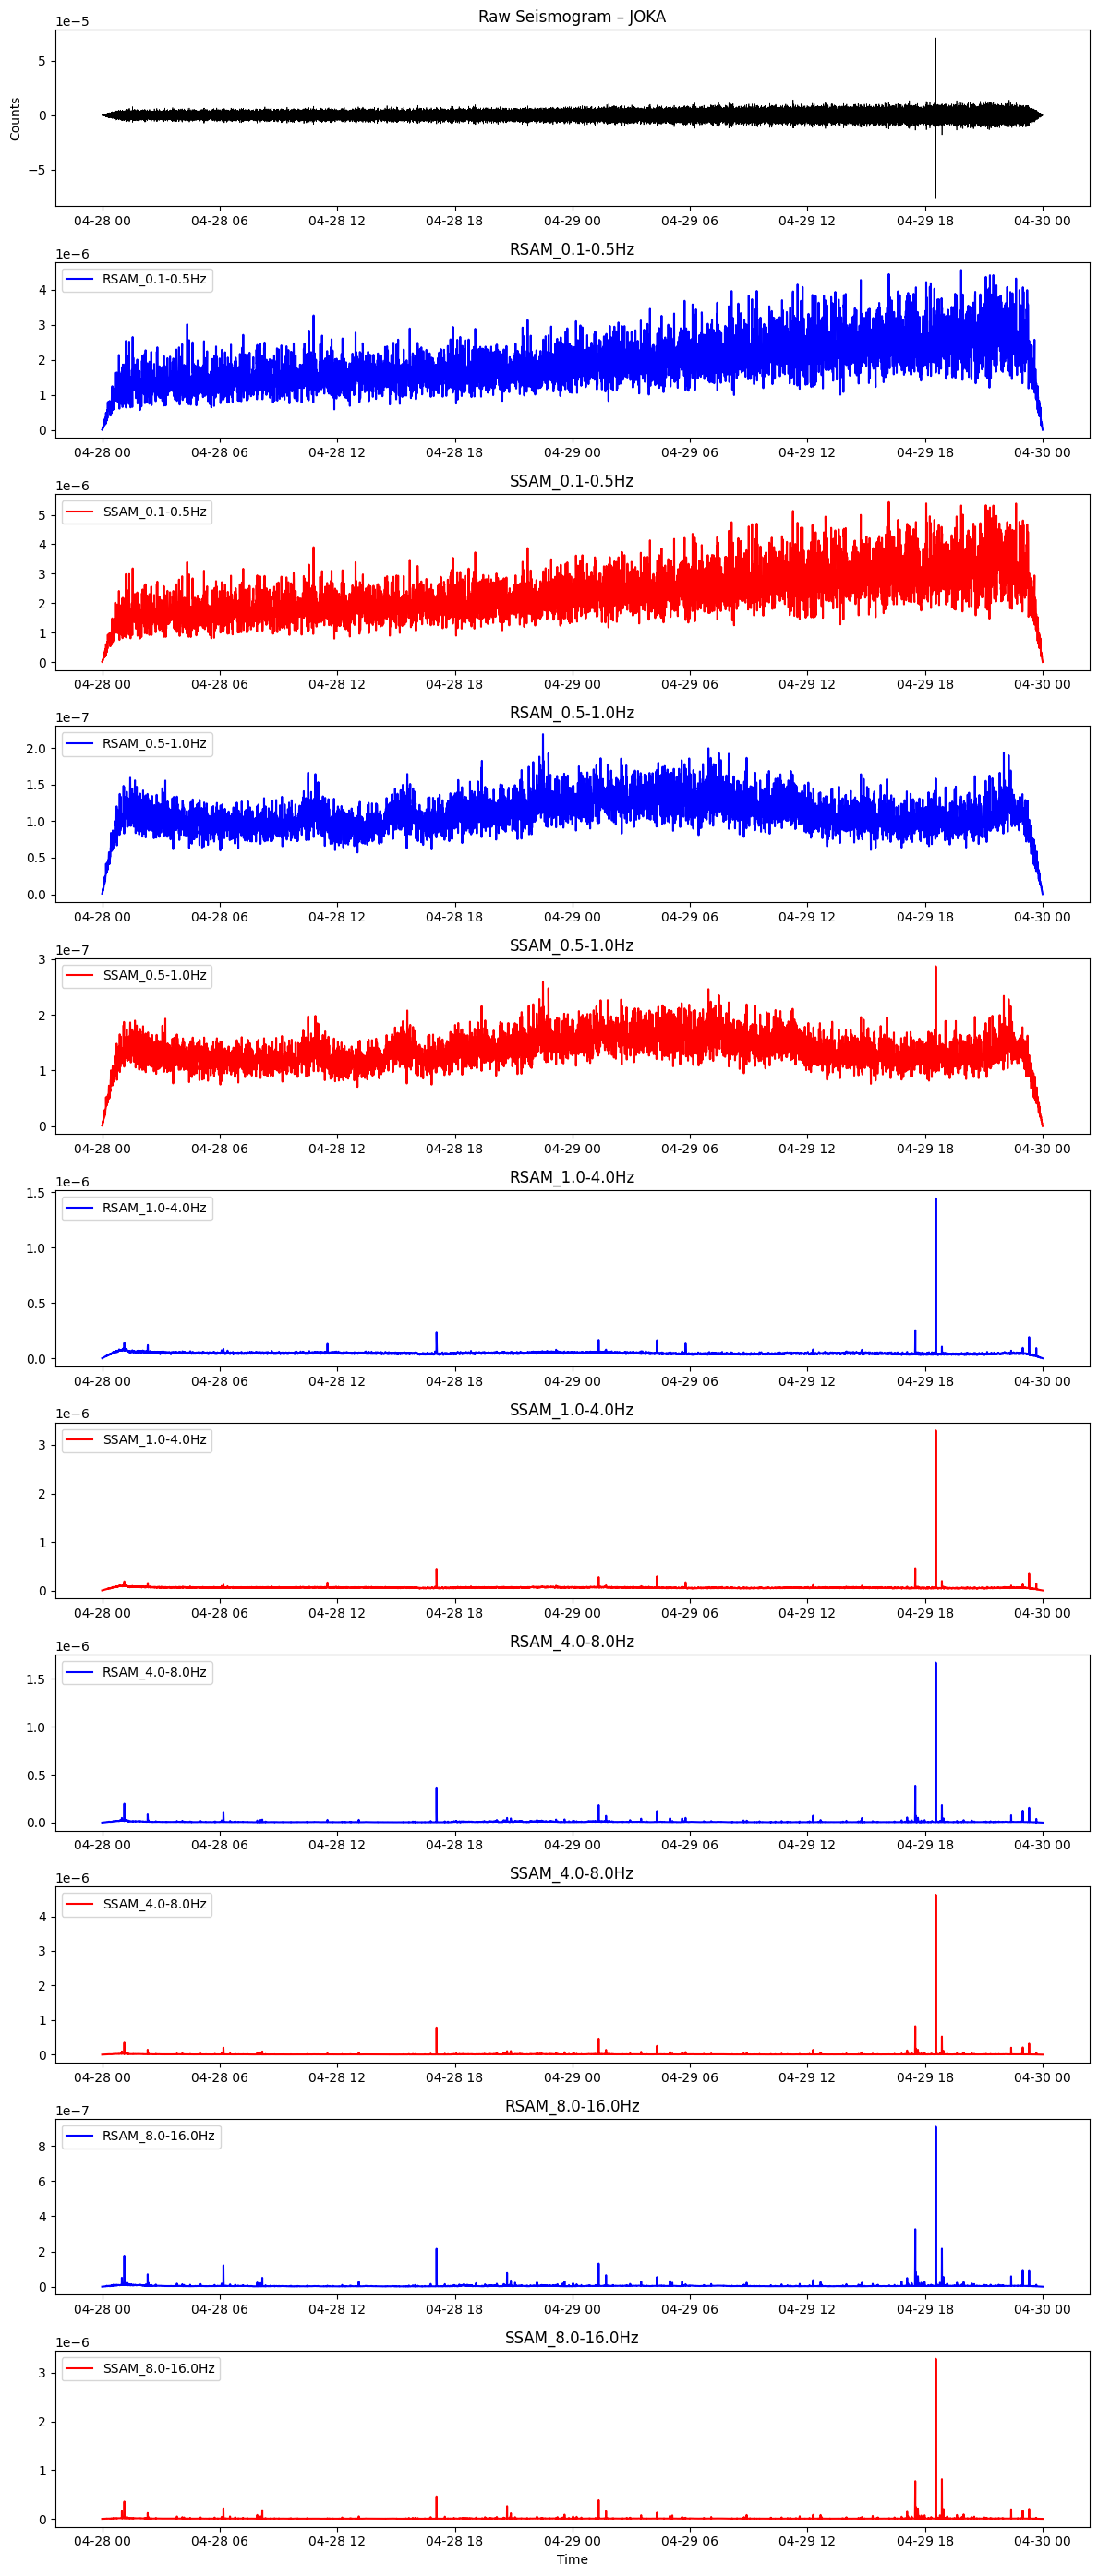


✓ All processing complete.
Outputs saved to:
/Users/christinaw/waveforms/Kilauea/single_station_rsam_ssam_equal_bands



In [5]:
#!/usr/bin/env python3
# ============================================================
# RSAM + SSAM for identical frequency bands
# ============================================================
"""
RSAM = band-filtered |amplitude| averaged over time window
SSAM = spectral RMS amplitude for same bands
https://github.com/ThomasLecocq/ssxm/blob/master/ssxm.py
Adapted from Thomas Lecocq (https://github.com/ThomasLecocq/ssxm)
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from obspy.signal.filter import bandpass


# ============================================================
# RSAM + SSAM FUNCTION
# ============================================================
def rsam_ssam(data, fs, trace_id, starttime, rule='30s', bands=None,
              corners=4, zerophase=False):

    if bands is None:
        bands = []

    data = data.astype(float)
    npts = len(data)
    dt = 1.0 / fs

    # pandas time index for the waveform
    t = pd.date_range(start=starttime, periods=npts, freq=f"{dt*1000}ms")
    s = pd.Series(data=data, index=t, name=trace_id)

    out = []

    # size of SSAM window
    window_sec = pd.Timedelta(rule).total_seconds()
    window_n = int(window_sec * fs)

    for fmin, fmax in bands:

        # ------------------------------------------------------
        # RSAM (band-filtered absolute amplitude)
        # ------------------------------------------------------
        filtered = bandpass(
            s.values, fmin, fmax,
            fs, corners=corners, zerophase=zerophase
        )
        abs_amp = np.abs(filtered)

        rsam_df = pd.DataFrame(index=s.index)
        rsam_df["RSAM"] = abs_amp
        rsam_df = rsam_df.resample(rule).mean()
        rsam_df["band"] = f"RSAM_{fmin}-{fmax}Hz"

        # ------------------------------------------------------
        # SSAM (spectral RMS per window)
        # ------------------------------------------------------
        ssam_vals = []
        ssam_times = []

        for i in range(0, len(abs_amp), window_n):
            seg = abs_amp[i:i + window_n]
            if len(seg) < 1:
                continue
            rms = np.sqrt(np.mean(seg ** 2))
            ssam_vals.append(rms)
            ssam_times.append(starttime + pd.Timedelta(seconds=i / fs))

        ssam_df = pd.DataFrame(index=pd.to_datetime(ssam_times))
        ssam_df["SSAM"] = ssam_vals
        ssam_df["band"] = f"SSAM_{fmin}-{fmax}Hz"

        # ------------------------------------------------------
        # Collect outputs
        # ------------------------------------------------------
        out.append(rsam_df)
        out.append(ssam_df)

    return pd.concat(out)


# ============================================================
# MAIN SCRIPT
# ============================================================
if __name__ == "__main__":

    # ---- USER SETTINGS ----
    station = "JOKA"
    network = "HV"
    rule = "30s"

    # IDENTICAL RSAM + SSAM bands
    bands = [
        [0.1, 0.5],
        [0.5, 1.0],
        [1.0, 4.0],
        [4.0, 8.0],
        [8.0, 16.0],
    ]

    base_dir = "/Users/christinaw/waveforms/Kilauea"
    wavefile = os.path.join(base_dir, "preconditioned_HV.JOKA.HHZ.2018-04-28.mseed")
    output_dir = os.path.join(base_dir, "single_station_rsam_ssam_equal_bands")
    os.makedirs(output_dir, exist_ok=True)

    print("\nReading waveform…")
    st = read(wavefile)
    st.detrend("demean")
    Z = st.select(component="Z")

    all_results = []

    for tr in Z:
        fs = tr.stats.sampling_rate
        trace_id = f"{network}.{station}.{tr.stats.channel}"
        starttime = tr.stats.starttime.datetime

        print(f"\nProcessing → {trace_id}")

        res = rsam_ssam(
            tr.data, fs, trace_id, starttime,
            rule=rule, bands=bands
        )
        all_results.append(res)

    # Merge all traces (usually 1 Z trace)
    df = pd.concat(all_results)
    df.to_csv(os.path.join(output_dir, f"{station}_RSAM_SSAM_all.csv"))
    print("\n✓ Saved merged RSAM+SSAM CSV")

    # Save per band
    for name, g in df.groupby("band"):
        out = os.path.join(output_dir, f"{station}_{name}.csv")
        g.to_csv(out)
        print(f"✓ Saved {name} → {out}")

    # ============================================================
    # PLOTTING
    # ============================================================
    print("\nPlotting RSAM & SSAM…")

    plt.figure(figsize=(12, 28))

    # 1. Raw waveform
    ax1 = plt.subplot(len(bands) * 2 + 1, 1, 1)
    plt.plot(tr.times("matplotlib"), tr.data, lw=0.5, color="black")
    plt.title(f"Raw Seismogram – {station}")
    plt.ylabel("Counts")

    row = 2
    for fmin, fmax in bands:

        # RSAM
        rs_name = f"RSAM_{fmin}-{fmax}Hz"
        rs = df[df["band"] == rs_name]

        ax = plt.subplot(len(bands) * 2 + 1, 1, row, sharex=ax1)
        plt.plot(rs.index, rs["RSAM"], label=rs_name, color="blue")
        plt.title(rs_name)
        plt.legend()
        row += 1

        # SSAM
        ss_name = f"SSAM_{fmin}-{fmax}Hz"
        ss = df[df["band"] == ss_name]

        ax = plt.subplot(len(bands) * 2 + 1, 1, row, sharex=ax1)
        plt.plot(ss.index, ss["SSAM"], label=ss_name, color="red")
        plt.title(ss_name)
        plt.legend()
        row += 1

    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()

    print("\n✓ All processing complete.")
    print(f"Outputs saved to:\n{output_dir}\n")



--- Processing HV.JOKA.HHZ.2018-04-28.mseed ---
  Trace: HV.JOKA.HHZ
  Saved: /Users/christinaw/waveforms/Kilauea/processed/HV.JOKA.2018-04-28_RSAM_SSAM.csv
  Plotting RSAM & SSAM…
  Saved figure: /Users/christinaw/waveforms/Kilauea/processed/HV.JOKA.2018-04-28_RSAM_SSAM.png


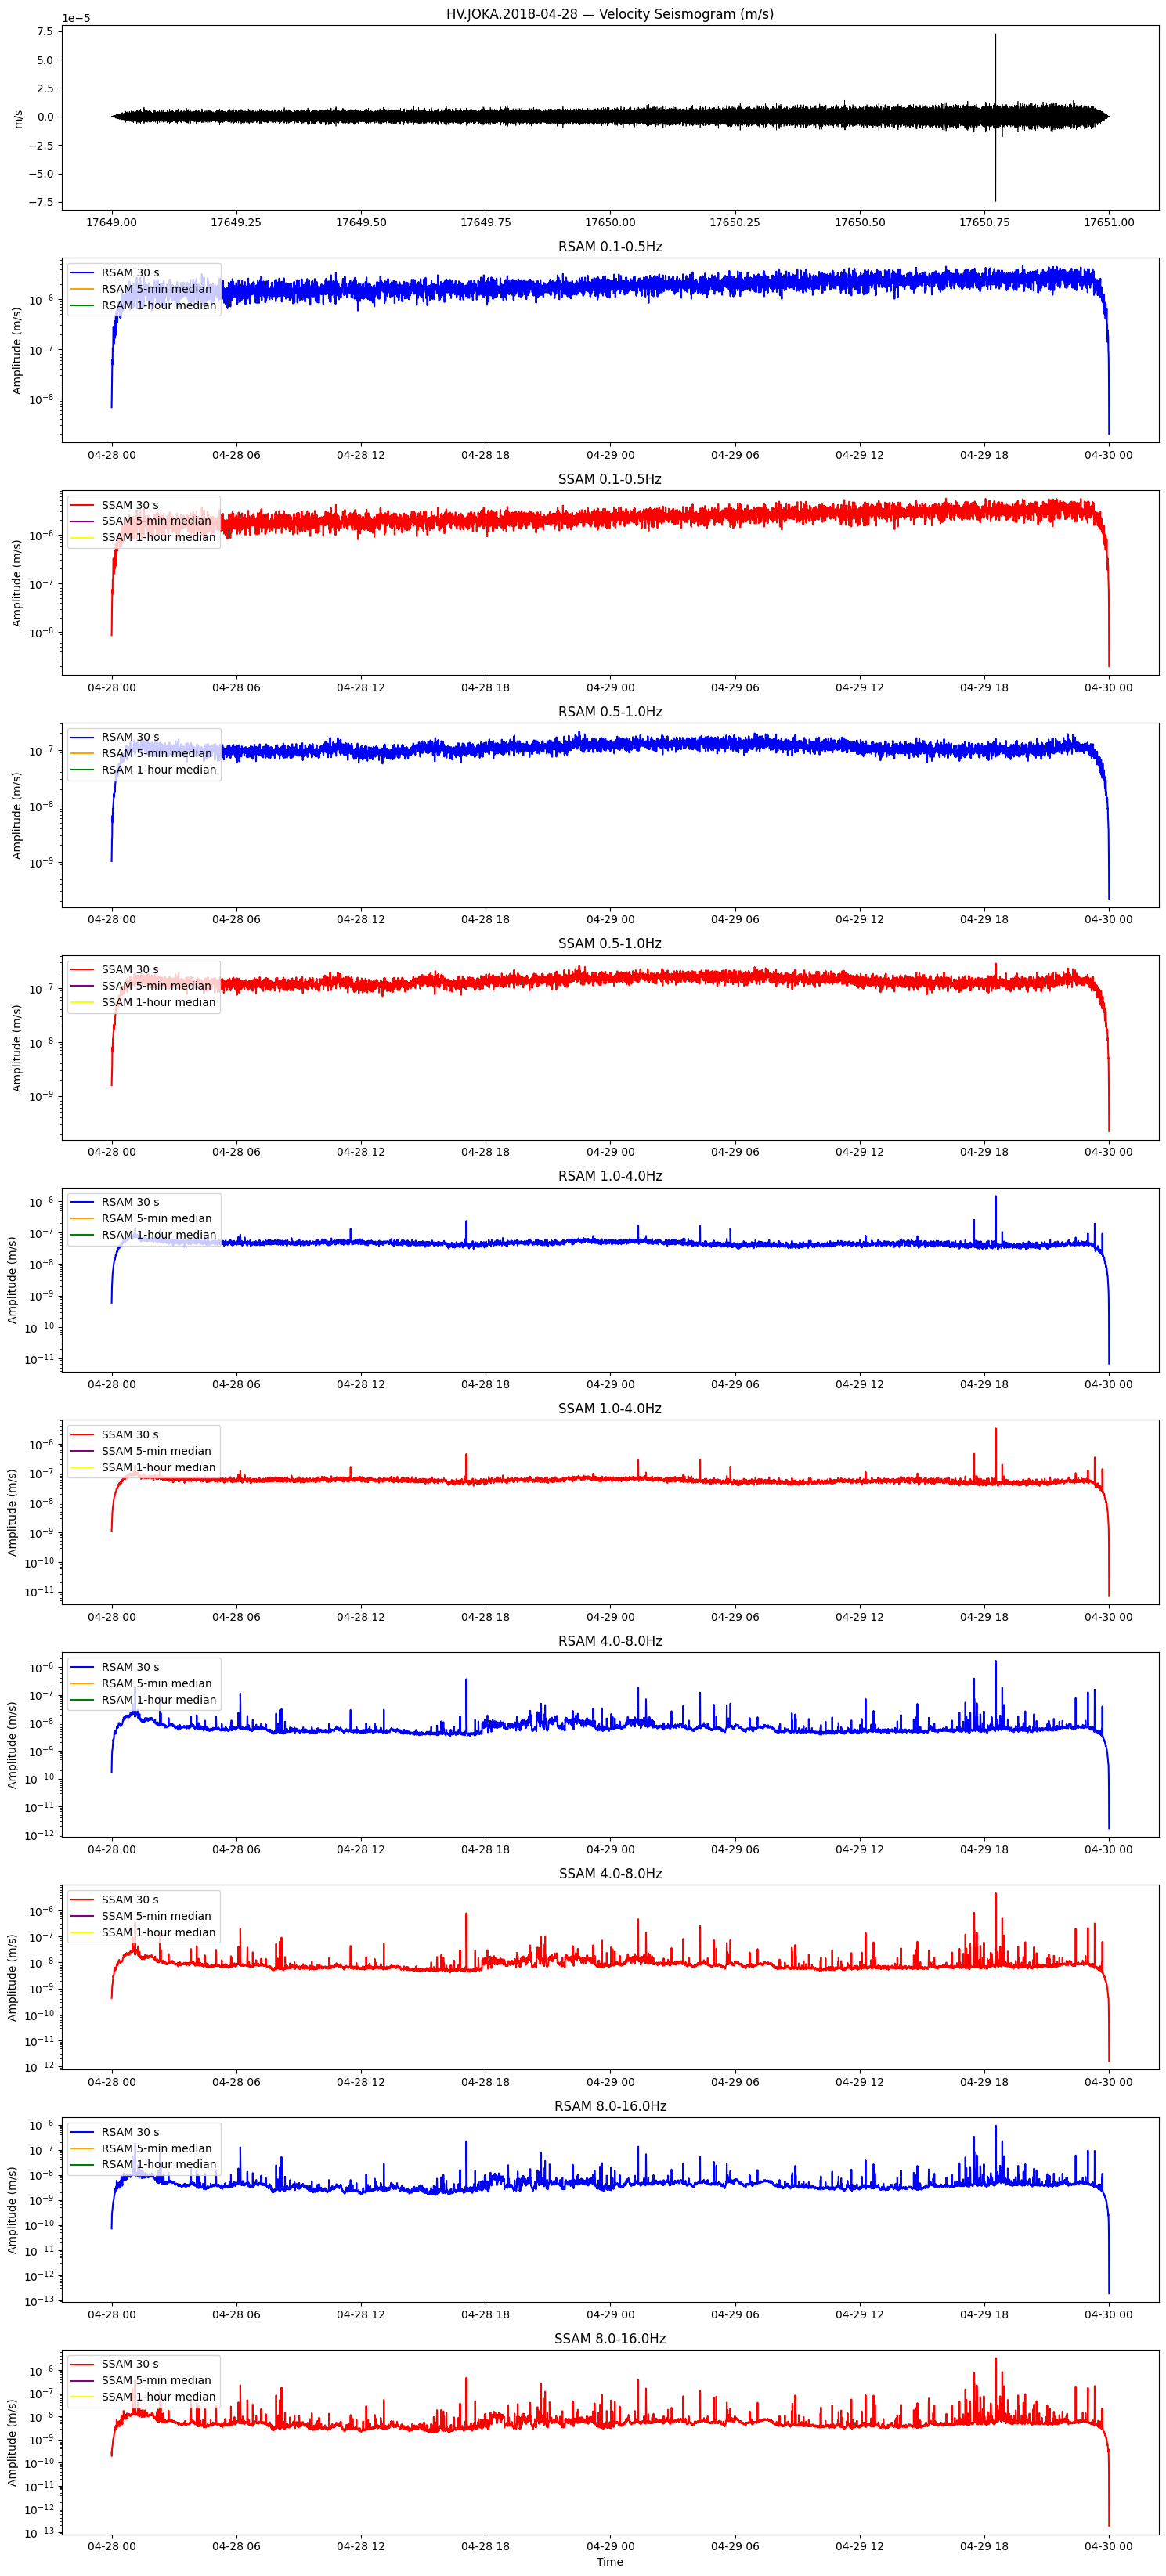


--- Processing HV.KLUD.HHZ.2018-04-28.mseed ---
  Trace: HV.KLUD.EHZ
  Saved: /Users/christinaw/waveforms/Kilauea/processed/HV.KLUD.2018-04-28_RSAM_SSAM.csv
  Plotting RSAM & SSAM…
  Saved figure: /Users/christinaw/waveforms/Kilauea/processed/HV.KLUD.2018-04-28_RSAM_SSAM.png


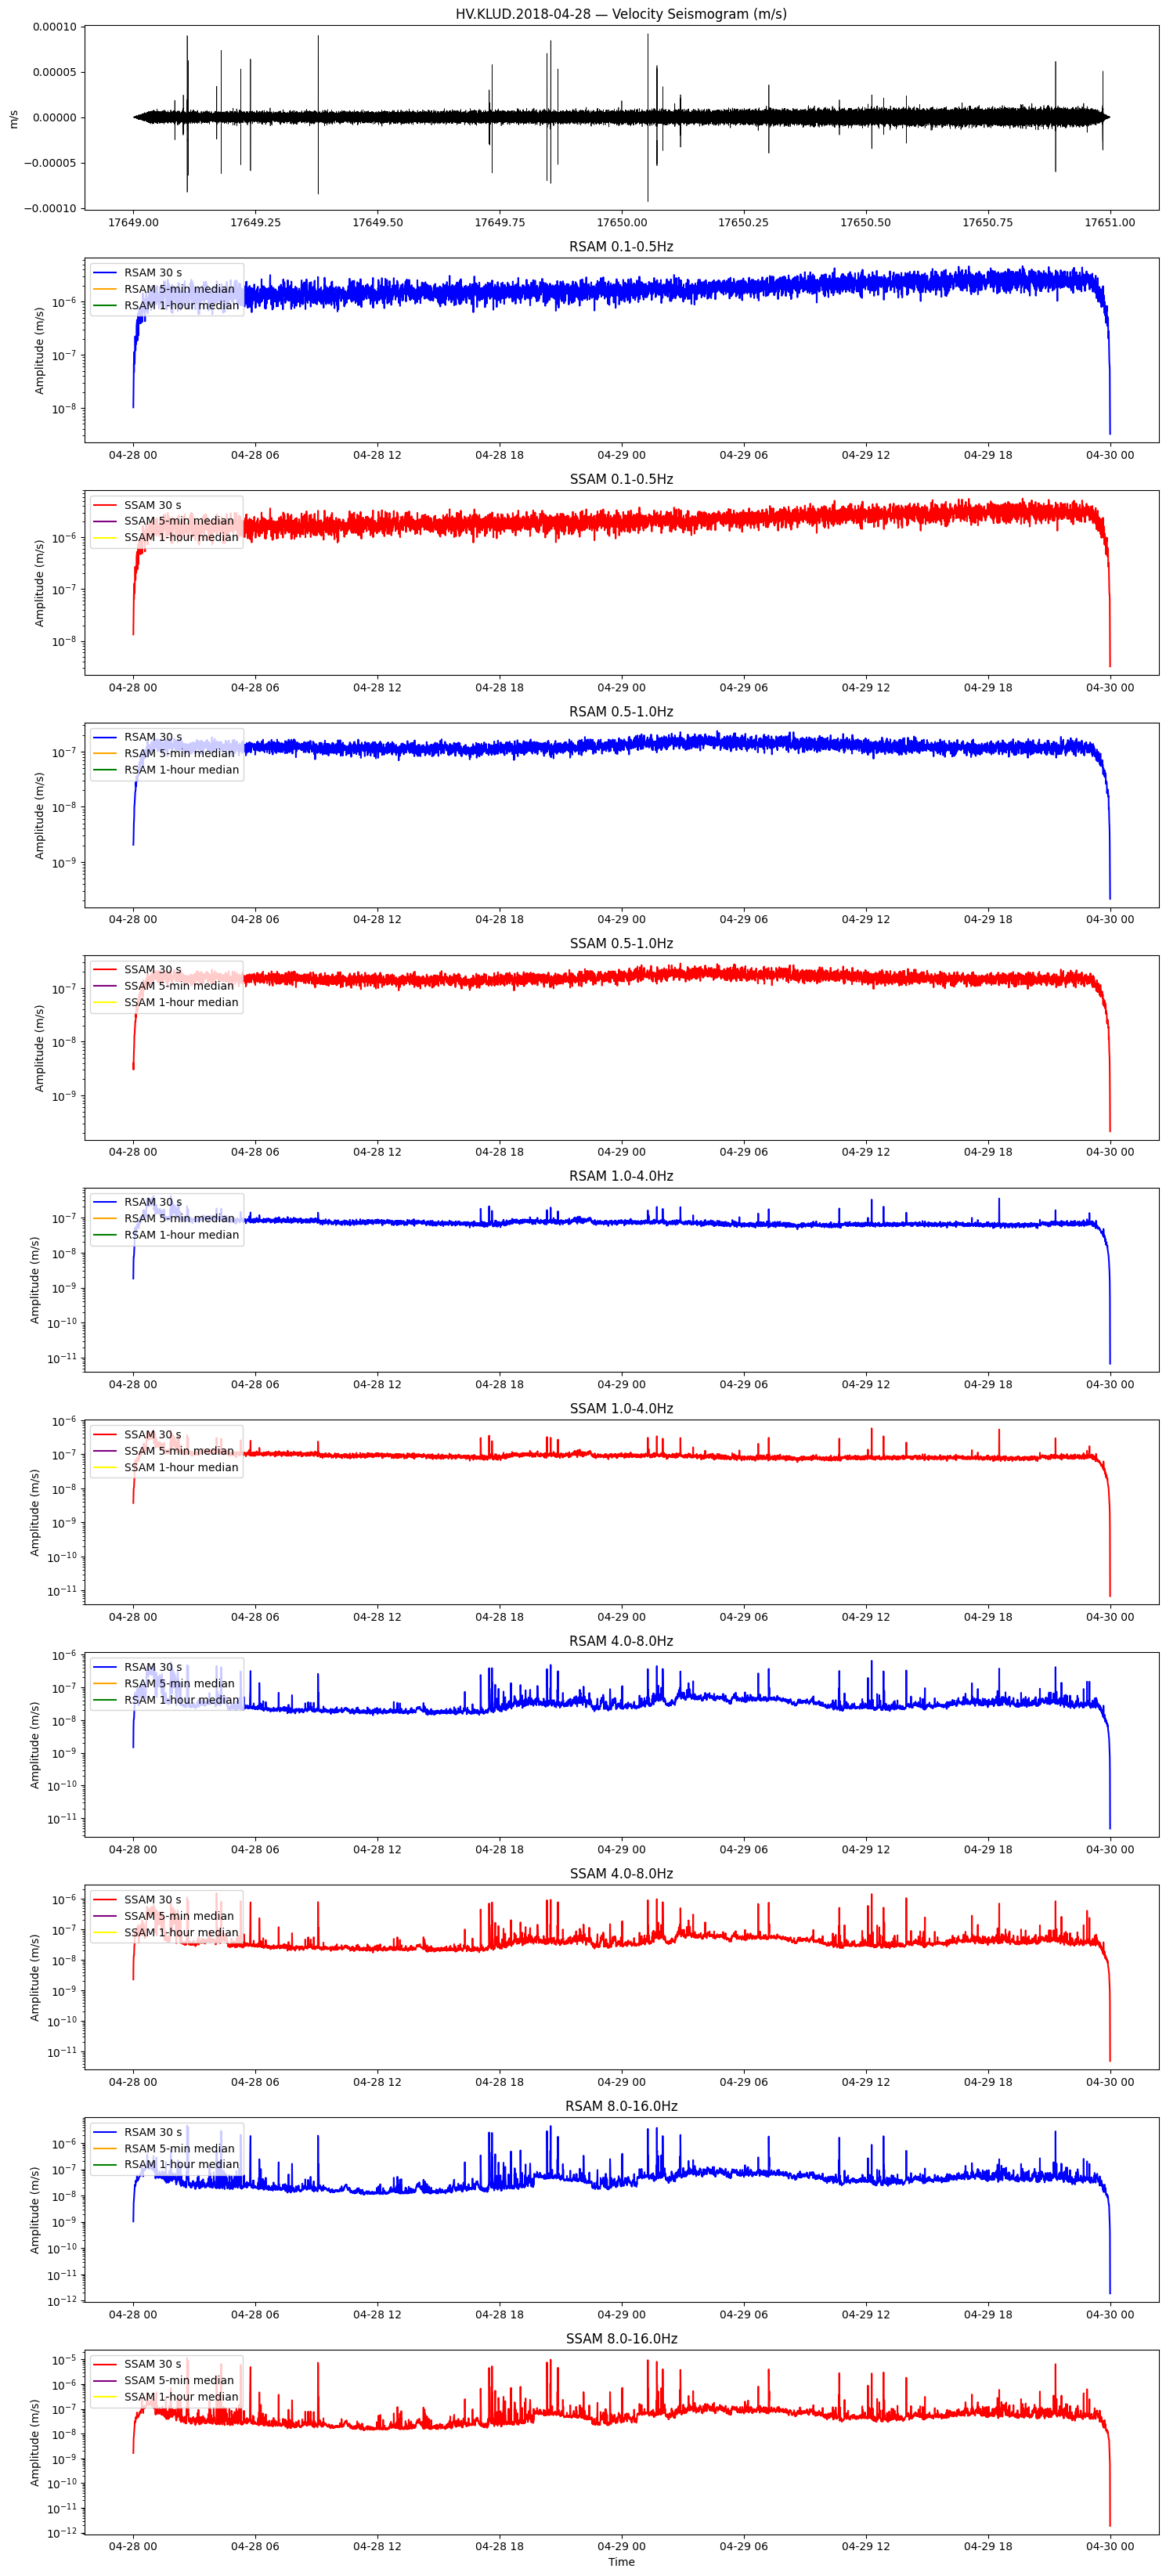


--- Processing HV.KUPD.EHZ.2018-04-28.mseed ---
  Trace: HV.KUPD.EHZ
  Saved: /Users/christinaw/waveforms/Kilauea/processed/HV.KUPD.2018-04-28_RSAM_SSAM.csv
  Plotting RSAM & SSAM…
  Saved figure: /Users/christinaw/waveforms/Kilauea/processed/HV.KUPD.2018-04-28_RSAM_SSAM.png


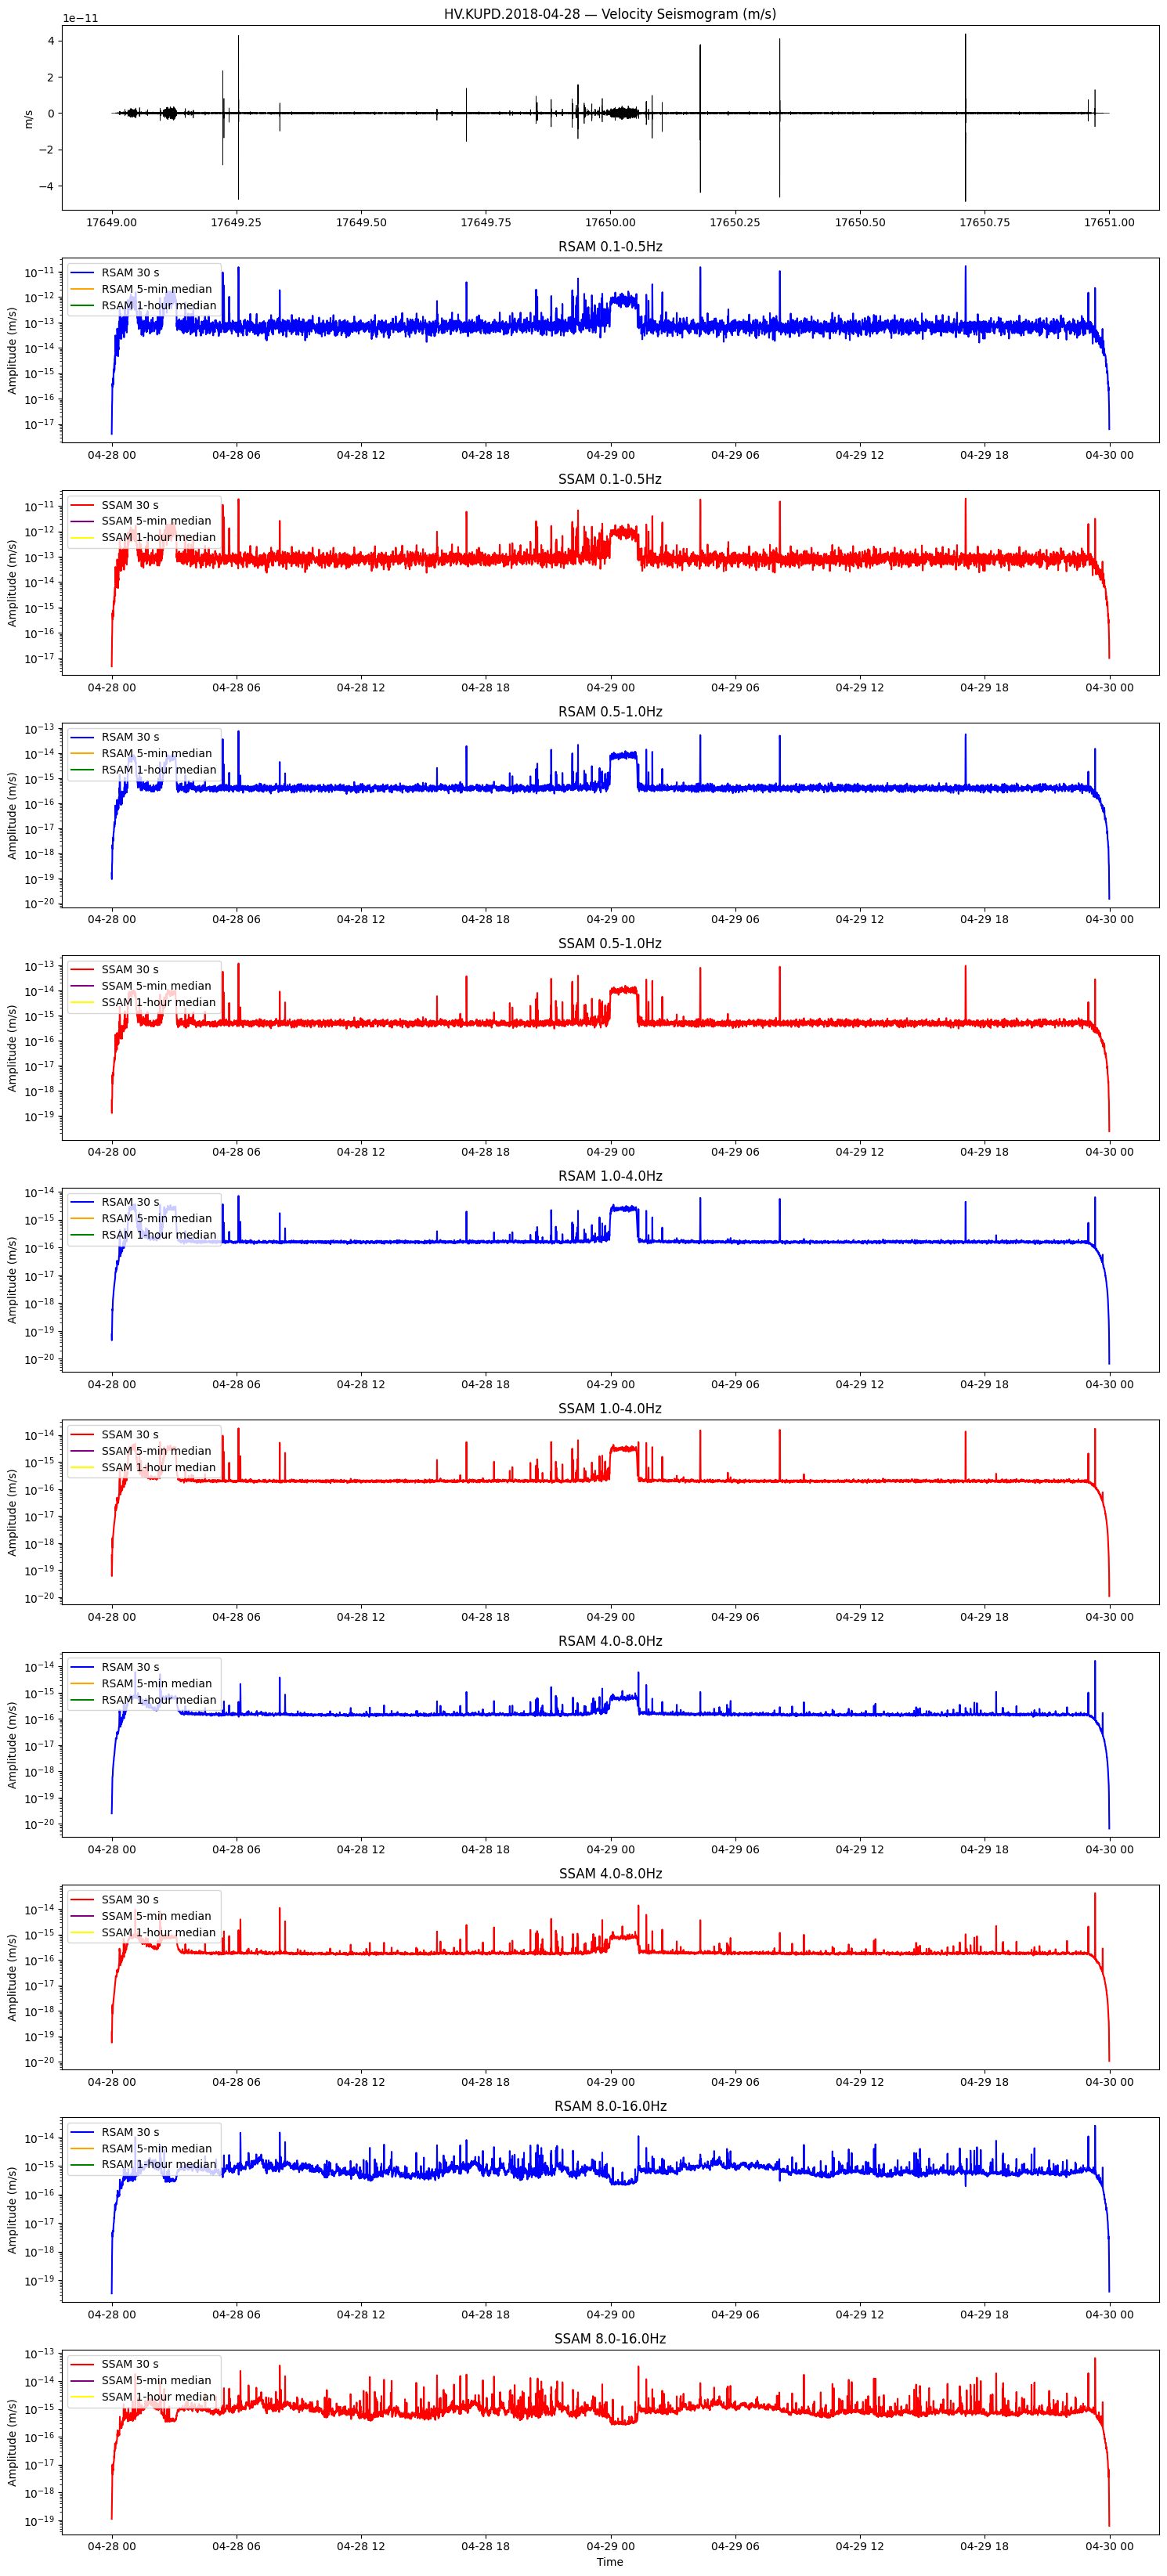


✓ All processing complete.
Outputs stored in:
/Users/christinaw/waveforms/Kilauea/processed


In [24]:
#!/usr/bin/env python3
# ============================================================
# Batch RSAM + SSAM with 5-min & 1-hour overlapping medians
# Overlayed on 30-second RSAM/SSAM
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from obspy.clients.fdsn import Client
from obspy.signal.filter import bandpass


# ------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------
volcano_name = "Kilauea"
network_list = ["HV"]

base_dir = "/Users/christinaw/waveforms"
waveform_dir = os.path.join(base_dir, "Kilauea_local_waveforms")
output_dir = os.path.join(base_dir, volcano_name, "processed")
os.makedirs(output_dir, exist_ok=True)

rule = "30s"   # RSAM/SSAM window
bands = [
    [0.1, 0.5],
    [0.5, 1.0],
    [1.0, 4.0],
    [4.0, 8.0],
    [8.0, 16.0],
]

client = Client("IRIS")


# ------------------------------------------------------------
# HELPER: Overlapping median windows
# ------------------------------------------------------------
def overlapping_median(series, window, overlap=0.5):
    series = series.sort_index()
    W = pd.Timedelta(window)
    H = W * (1 - overlap)

    start = series.index[0]
    end = series.index[-1]

    out_vals, out_times = [], []
    t = start

    while t + W <= end:
        seg = series.loc[t:t + W]
        if len(seg) > 0:
            out_times.append(t + W/2)
            out_vals.append(seg.median())
        t += H

    return pd.Series(out_vals, index=pd.to_datetime(out_times))


# ------------------------------------------------------------
# RSAM + SSAM
# ------------------------------------------------------------
def compute_rsam_ssam(data, fs, starttime, rule, bands):
    data = data.astype(float)
    npts = len(data)
    dt = 1 / fs

    t = pd.date_range(start=starttime, periods=npts, freq=f"{dt*1000}ms")
    s = pd.Series(data=data, index=t)

    out = []
    win_sec = pd.Timedelta(rule).total_seconds()
    win_samples = int(win_sec * fs)

    for fmin, fmax in bands:
        band_label = f"{fmin}-{fmax}Hz"

        # RSAM: mean |amplitude|
        filtered = bandpass(s.values, fmin, fmax, fs,
                            corners=4, zerophase=False)
        abs_amp = np.abs(filtered)

        df_rsam = pd.DataFrame(index=s.index)
        df_rsam["value"] = abs_amp
        df_rsam = df_rsam.resample(rule).mean()
        df_rsam["metric"] = "RSAM"
        df_rsam["band"] = band_label

        # SSAM: RMS per 30 s window
        ss_vals, ss_times = [], []
        for i in range(0, len(abs_amp), win_samples):
            seg = abs_amp[i:i + win_samples]
            if len(seg) == 0: continue
            ss_vals.append(np.sqrt(np.mean(seg ** 2)))
            ss_times.append(starttime + pd.Timedelta(seconds=i/fs))

        df_ssam = pd.DataFrame(index=pd.to_datetime(ss_times),
                               data={"value": ss_vals})
        df_ssam["metric"] = "SSAM"
        df_ssam["band"] = band_label

        out.append(df_rsam)
        out.append(df_ssam)

    return pd.concat(out).sort_index()


# ------------------------------------------------------------
# Add overlapping median envelopes
# ------------------------------------------------------------
def add_median_envelopes(df):
    groups_out = []

    for (metric, band), g in df.groupby(["metric", "band"]):
        g = g.sort_index().copy()
        series = g["value"]

        med_5 = overlapping_median(series, "5min", overlap=0.5)
        med_1 = overlapping_median(series, "1h", overlap=0.5)

        g["median_5min"] = med_5.reindex(g.index)
        g["median_1h"] = med_1.reindex(g.index)

        groups_out.append(g)

    return pd.concat(groups_out).sort_index()


# ------------------------------------------------------------
# Process waveform
# ------------------------------------------------------------
def process_waveform_file(filepath):
    print(f"\n--- Processing {os.path.basename(filepath)} ---")

    st = read(filepath)
    st.detrend("demean")

    Z = st.select(component="Z")
    if len(Z) == 0:
        print("  No Z trace, skipping.")
        return None, None, None

    tr = Z[0]
    net, sta, cha = tr.stats.network, tr.stats.station, tr.stats.channel

    print(f"  Trace: {net}.{sta}.{cha}")

    # Fetch response
    inv = client.get_stations(
        network=net, station=sta, channel=cha,
        starttime=tr.stats.starttime, endtime=tr.stats.endtime,
        level="response"
    )

    # Remove response → velocity
    tr2 = tr.copy()
    tr2.remove_response(inventory=inv, output="VEL",
                        pre_filt=(0.01, 0.02, 15, 20),
                        zero_mean=True, taper=True)

    fs = tr2.stats.sampling_rate
    starttime = tr2.stats.starttime.datetime

    # RSAM + SSAM
    df = compute_rsam_ssam(tr2.data, fs, starttime, rule, bands)

    # 5-min & 1-hour overlapping medians
    df = add_median_envelopes(df)

    return df, tr, tr2


# ------------------------------------------------------------
# MAIN
# ------------------------------------------------------------
if __name__ == "__main__":

    files = sorted([f for f in os.listdir(waveform_dir)
                    if f.endswith((".mseed", ".ms"))])

    for fname in files:
        parts = fname.split(".")
        if len(parts) < 4:
            continue

        net, sta, date = parts[0], parts[1], parts[3]
        if net not in network_list:
            continue

        filepath = os.path.join(waveform_dir, fname)
        df, tr_raw, tr_vel = process_waveform_file(filepath)
        if df is None:
            continue

        base_name = f"{net}.{sta}.{date}"

        # Save CSV
        csv_path = os.path.join(output_dir, f"{base_name}_RSAM_SSAM.csv")
        df.to_csv(csv_path)
        print(f"  Saved: {csv_path}")

        # --------------------------------------------------------
        # PLOTTING
        # --------------------------------------------------------
        print("  Plotting RSAM & SSAM…")

        fig_rows = 1 + 2*len(bands)
        fig, axes = plt.subplots(fig_rows, 1, figsize=(15, 3*fig_rows))

        # Raw velocity trace
        ax0 = axes[0]
        ax0.plot(tr_vel.times("matplotlib"), tr_vel.data, lw=0.5, color="black")
        ax0.set_title(f"{base_name} — Velocity Seismogram (m/s)")
        ax0.set_ylabel("m/s")

        row = 1
        for fmin, fmax in bands:

            band_label = f"{fmin}-{fmax}Hz"

            # =====================================================
            # RSAM subplot
            # =====================================================
            ax = axes[row]
            sub = df[(df["metric"] == "RSAM") & (df["band"] == band_label)]

            # COLORS you requested
            ax.semilogy(sub.index, sub["value"],        color="blue",   label="RSAM 30 s")
            ax.semilogy(sub.index, sub["median_5min"],  color="orange", label="RSAM 5-min median")
            ax.semilogy(sub.index, sub["median_1h"],    color="green",  label="RSAM 1-hour median")

            ax.set_title(f"RSAM {band_label}")
            ax.set_ylabel("Amplitude (m/s)")
            ax.legend(loc="upper left")
            row += 1

            # =====================================================
            # SSAM subplot
            # =====================================================
            ax = axes[row]
            sub = df[(df["metric"] == "SSAM") & (df["band"] == band_label)]

            # COLORS you requested
            ax.semilogy(sub.index, sub["value"],        color="red",    label="SSAM 30 s")
            ax.semilogy(sub.index, sub["median_5min"],  color="purple", label="SSAM 5-min median")
            ax.semilogy(sub.index, sub["median_1h"],    color="yellow", label="SSAM 1-hour median")

            ax.set_title(f"SSAM {band_label}")
            ax.set_ylabel("Amplitude (m/s)")
            ax.legend(loc="upper left")
            row += 1

        axes[-1].set_xlabel("Time")
        plt.tight_layout()

        fig_path = os.path.join(output_dir, f"{base_name}_RSAM_SSAM.png")
        plt.savefig(fig_path, dpi=200)
        print(f"  Saved figure: {fig_path}")

        plt.show()
        plt.close(fig)


    print("\n✓ All processing complete.")
    print(f"Outputs stored in:\n{output_dir}")
